# **Trumpyboi's deep learning adventures :)**


In [1]:
# Imports for loading and preprocessing the data
import json
import re 
import nltk
from nltk.tokenize import TweetTokenizer

# Imports to create skip-gram embedding
import gensim.downloader as api
from gensim.models import Word2Vec

# From IPython.display we import clear_output() in order to be able to clear the print statements after each epoch
from IPython.display import clear_output

import tensorflow as tf
# Next line only for colab
%tensorflow_version 2.x
from tensorflow.keras import Model
tfkl = tf.keras.layers

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm, tqdm_notebook # show progress bar

# Imports for latent space analysis
from bokeh.models import Title
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Colorblind3                    # Color palette
from bokeh.models import ColumnDataSource               # Allows creating a column dataset for convenient plotting
from bokeh.transform import factor_cmap                 # To apply color palette to our 2 classes
from bokeh.io import output_notebook                    # Allows to display the bokeh plot in colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Dataset**

Loading the dataset:

In [3]:
trump_tweets = []   
with open("drive/MyDrive/Final_Project/Dataset/tweets_01-08-2021.json") as f:
  for line in tqdm(json.load(f)):
    if line["isRetweet"] == "f":
      trump_tweets.append(line["text"])

100%|██████████| 56571/56571 [00:00<00:00, 1824161.41it/s]


Total Number of Tweets before preprocessing:

In [4]:
print(len(trump_tweets))

46694


### Preprocessing

Preprocessing will involve the following steps:
*   Removing artifacts like "(cont)" which can be found in numerous tweets that included images, Links and several (reocurring) special characters
*   Replacing certain parts of a tweet with a single token e.g. Numbers with "\<NUM>" and "&amp" with "and"
*   Tokenizing
*   Only keeping tweets containing words with a frequency >1
*   Prepend start of sequence (sos) token "\<START>" and append end of sequence (eos) token "\<END>" to every tweet

*   Use the resulting dataset to create two new datasets:
  *   One for training the skip-gram model
  *   One including input, target, teacher pairs for training the LaTextGAN








In [5]:
# Maybe add apostrophe again for words like don't, remove *, maybe [^\p{Latin}!.,*\-#?@%$+\/' ]

# Removing/Replacing special characters etc.
trump_tweets_clean = [re.sub(r'\(cont\)|[\'’"]|http\S+|\n', '',tweet.replace("\'", "'").replace("&amp", "and")) for tweet in trump_tweets]

trump_tweets_clean = [re.sub(r'\.\.+|—+|-+|\*\*+', ' ',tweet) for tweet in trump_tweets_clean]

trump_tweets_clean = [re.sub(r'\d+\b', ' <NUM> ', tweet) for tweet in trump_tweets_clean]

# Print example tweets
trump_tweets_clean[5985:5990]


['I did more in  <NUM>  months as President than Joe Biden did in  <NUM>  years! ',
 '',
 'I will be signing my Executive Order prohibiting immigration into our Country today. In the meantime, even without this order, our Southern Border, aided substantially by the  <NUM>  miles of new Border Wall and;  <NUM> , <NUM>  Mexican soldiers, is very tight   including for human trafficking!',
 'Will be in the Great State of South Carolina tonight,  <NUM> : <NUM>  P.M., for a really BIG Rally. Best place to be is a Trump Rally. See you later!',
 'Please let this serve as my Complete and Total Endorsement of a great fighter and ally in North Carolina, @LyndaBennettNC. She is strong on Crime, Borders, Military, our Great Vets and; 2A. She will be a great help to me in DC. EARLY VOTING STARTS TODAY. We need Lynda Bennett! #NC <NUM> ']

In [6]:
# Apply nltk's tweettokenizer (allows us to keep hashtags e.g. #govote and mentions e.g. @realdonaldtrump), we also lowercase all tokens
trump_tweets_tokenized = [TweetTokenizer(preserve_case=False).tokenize(tweet) for tweet in trump_tweets_clean]


# Removing empty tweets
trump_tweets_tokenized = [tweet for tweet in trump_tweets_tokenized if tweet != []]


# Removing very long tweets that contain tokens from a different language
print(trump_tweets_tokenized[4636])
del trump_tweets_tokenized[4636]
print(trump_tweets_tokenized[4644])
del trump_tweets_tokenized[4644]
print(trump_tweets_tokenized[4651])
del trump_tweets_tokenized[4651]

# Create a frequency dict of all tokens
freqs = {}
for tweet in trump_tweets_tokenized:
  for word in tweet:
    freqs[word] = freqs.get(word, 0) + 1 

# Removing all words that occurr less than two times and remove the tweets containing them
remove=False
cache = []
for tweet in trump_tweets_tokenized:
  for word in tweet:
    if freqs[word]==1:
      remove=True
  if remove == False:
    cache.append(tweet)
  remove=False 

trump_tweets_tokenized = cache
print()
print(f"Remaining tweets after preprocesing: {len(trump_tweets_tokenized)}")

['प', '्', 'रथम', 'मह', 'ि', 'ल', 'ा', 'और', 'म', 'ै', 'ं', 'इस', 'द', 'े', 'श', 'क', 'े', 'हर', 'न', 'ा', 'गर', 'ि', 'क', 'क', 'ो', 'एक', 'सन', '्', 'द', 'े', 'श', 'द', 'े', 'न', 'े', 'क', 'े', 'ल', 'ि', 'ए', 'द', 'ु', 'न', 'ि', 'य', 'ा', 'क', 'ा', '<num>', 'म', 'ी', 'ल', 'क', 'ा', 'चक', '्', 'कर', 'लग', 'ा', 'कर', 'यह', 'ा', 'ं', 'आय', 'े', 'ह', 'ै', 'ं', 'l', 'अम', 'े', 'र', 'ि', 'क', 'ा', 'भ', 'ा', 'रत', 'क', 'ो', 'प', '्', 'र', 'े', 'म', 'करत', 'ा', 'ह', 'ै', 'अम', 'े', 'र', 'ि', 'क', 'ा', 'भ', 'ा', 'रत', 'क', 'ा', 'सम', '्', 'म', 'ा', 'न', 'करत', 'ा', 'ह', 'ै', 'और', 'अमर', 'ी', 'क', 'ा', 'क', 'े', 'ल', 'ो', 'ग', 'हम', 'े', 'श', 'ा', 'भ', 'ा', 'रत', 'क', 'े', 'ल', 'ो', 'ग', 'ो', 'ं', 'क', 'े', 'सच', '्', 'च', 'े', 'और', 'न', 'ि', 'ष', '्', 'ठ', 'ा', 'व', 'ा', 'न', 'द', 'ो', 'स', '्', 'त', 'रह', 'े', 'ं', 'ग', 'े', 'l']
['अम', 'े', 'र', 'ि', 'क', 'ा', 'और', 'भ', 'ा', 'रत', 'अपन', 'े', 'द', 'े', 'श', 'ो', 'ं', 'क', 'ो', 'मजब', 'ू', 'त', 'बन', 'ा', 'ए', 'ँ', 'ग', 'े', ',', 'अपन', 'े

Train data is of form (input, target, teacher), where:


*   **Input** contains the tweets with both sos and eos tokens. This will be fed into the encoder of our Autoencoder.

*   **Target** contains the tweets with only the eos token. This will be used to calculate the loss of our Autoencoder.

*   **Teacher** contains the tweets with only the sos token. This will be used as the input for the decoder during training since we use teacher forcing.








In [7]:
# Shuffle the dataset once, to obtain random train and test partitions later
random.shuffle(trump_tweets_tokenized)

# Add start and end of sequence token to every tweet
# and create the two datasets
train_data = []
word2vec_data = []

for tweet in trump_tweets_tokenized:
  tweet.insert(len(tweet), "<End>")
  tweet.insert(0, "<Start>")
  train_data.append((tweet, tweet[1:], tweet[:-1]))
  word2vec_data.append(tweet)

Figuring out max length out of all tweets in our dataset in order to set the max sequence length that our decoder can generate in inference mode.

In [9]:
max_length = 0
idx = 0
for tweet in trump_tweets_tokenized:
  if len(tweet) > max_length:
    max_length = len(tweet)

print(f"Longest Tweet has {max_length} tokens.")  

Longest Tweet has 78 tokens.


### Create Embedding

We use gensim's word2vec function that trains a skip-gram model (with negative sampling) for 20 epochs to create an 200 dimensional embedding.

In [12]:
word2vec_model = Word2Vec(sentences=word2vec_data, size=200, window=5, min_count=1, workers=4, sg=1, negative=50, iter = 20)
# Save the trained embeddings
word2vec_model.save("drive/MyDrive/Final_Project/Rare_Words_Removed/skip_gram_embedding.model")

In [13]:
# Load previously saved embeddings
word2vec_model = Word2Vec.load("drive/MyDrive/Final_Project/Rare_Words_Removed/skip_gram_embedding.model")

In [16]:
vocab_size = len(word2vec_model.wv.vocab)
print(f"Vocab size of our word2vec model: {vocab_size}")

Vocab size of our word2vec model: 16203


Convert the word2vec model word vectors into a numpy matrix that is suitable for insertion into our TensorFlow/Keras embedding layer.

In [ ]:

embedding_matrix = np.zeros((len(word2vec_model.wv.vocab), 200))
for i in range(len(word2vec_model.wv.vocab)):
    embedding_vector = word2vec_model.wv[word2vec_model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# add row to shift matrix (since padding value is 0)
embedding_matrix = np.insert(arr=embedding_matrix, obj=0, values=np.zeros(200), axis=0)

embedding_matrix.shape

(16205, 200)

In [ ]:
word2index_dict = {token: token_index for token_index, token in enumerate(word2vec_model.wv.index2word)}

tweets2index_input = []
tweets2index_target = []
tweets2index_teacher_forcing = []

# +1 to each index as we use zero paddding (therefore zeros ned to be ignored) and masking
for input, target, teacher in train_data:
  input = [word2index_dict[key]+1 for key in input]
  target = [word2index_dict[key]+1 for key in target]
  teacher = [word2index_dict[key]+1 for key in teacher]
  tweets2index_input.append(input)
  tweets2index_target.append(target)
  tweets2index_teacher_forcing.append(teacher)

print(tweets2index_input[0])
print(tweets2index_teacher_forcing[0])
tweets2index_target[0]

[2, 39, 5, 250, 779, 136, 163, 36, 122, 35, 1, 38, 1154, 496, 1441, 1, 15, 483, 6, 3]
[2, 39, 5, 250, 779, 136, 163, 36, 122, 35, 1, 38, 1154, 496, 1441, 1, 15, 483, 6]


[39,
 5,
 250,
 779,
 136,
 163,
 36,
 122,
 35,
 1,
 38,
 1154,
 496,
 1441,
 1,
 15,
 483,
 6,
 3]

In [ ]:
word2index_dict["."]

0

### Data Pipeline, Maybe add Testset

In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_ragged_dataset_input = tf.ragged.constant(tweets2index_input[0:int(len(tweets2index_input)*0.9)])
train_ragged_dataset_target = tf.ragged.constant(tweets2index_target[0:int(len(tweets2index_target)*0.9)])
train_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[0:int(len(tweets2index_teacher_forcing)*0.9)])

train_dataset_input = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_input)
train_dataset_target = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_target)
train_dataset_teacher = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_teacher)

#convert ragged tensors to dense tensor see: https://github.com/tensorflow/tensorflow/issues/39163
train_dataset_input = train_dataset_input.map(lambda x: x)
train_dataset_target = train_dataset_target.map(lambda x: x)
train_dataset_teacher = train_dataset_teacher.map(lambda x: x)

train_dataset = tf.data.Dataset.zip((train_dataset_input, train_dataset_target, train_dataset_teacher)).cache().shuffle(buffer_size=50000, reshuffle_each_iteration=True).padded_batch(50).prefetch(tf.data.experimental.AUTOTUNE)


#Repeat for test data

#train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
test_ragged_dataset_input = tf.ragged.constant(tweets2index_input[int(len(tweets2index_input)*0.9):len(tweets2index_input)])
test_ragged_dataset_target = tf.ragged.constant(tweets2index_target[int(len(tweets2index_target)*0.9):len(tweets2index_target)])
test_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[int(len(tweets2index_teacher_forcing)*0.9):len(tweets2index_teacher_forcing)])

test_dataset_input = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_input)
test_dataset_target = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_target)
test_dataset_teacher = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_teacher)

#convert ragged tensors to dense tensor see: https://github.com/tensorflow/tensorflow/issues/39163
test_dataset_input = test_dataset_input.map(lambda x: x)
test_dataset_target = test_dataset_target.map(lambda x: x)
test_dataset_teacher = test_dataset_teacher.map(lambda x: x)

test_dataset = tf.data.Dataset.zip((test_dataset_input, test_dataset_target, test_dataset_teacher)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).padded_batch(50).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for input, target, teacher in train_dataset.take(1):
  print(input)
  print(target)
  print(teacher)
  train_tweet_for_visualisation_1 = (input[0], teacher[0])
  train_tweet_for_visualisation_2 = (input[1], teacher[1])

tf.Tensor(
[[   2  601  304 ...    0    0    0]
 [   2   28    9 ...    0    0    0]
 [   2   18   19 ...    0    0    0]
 ...
 [   2  342   26 ...    0    0    0]
 [   2 1541 3698 ...    0    0    0]
 [   2   24   12 ...    0    0    0]], shape=(50, 70), dtype=int32)
tf.Tensor(
[[ 601  304    8 ...    0    0    0]
 [  28    9   21 ...    0    0    0]
 [  18   19  401 ...    0    0    0]
 ...
 [ 342   26   39 ...    0    0    0]
 [1541 3698  476 ...    0    0    0]
 [  24   12  716 ...    0    0    0]], shape=(50, 69), dtype=int32)
tf.Tensor(
[[   2  601  304 ...    0    0    0]
 [   2   28    9 ...    0    0    0]
 [   2   18   19 ...    0    0    0]
 ...
 [   2  342   26 ...    0    0    0]
 [   2 1541 3698 ...    0    0    0]
 [   2   24   12 ...    0    0    0]], shape=(50, 69), dtype=int32)


In [ ]:
for input, target, teacher in test_dataset.take(1):
  print(input)
  print(target)
  print(teacher)
  test_tweet_for_visualisation_1 = (input[0], teacher[0])
  test_tweet_for_visualisation_2 = (input[1], teacher[1])

tf.Tensor(
[[    2     9  6406 ...     0     0     0]
 [    2    15   114 ...     0     0     0]
 [    2  5117  3555 ...     0     0     0]
 ...
 [    2    13    37 ...     0     0     0]
 [    2   469 11754 ...     0     0     0]
 [    2  8380    20 ...     0     0     0]], shape=(50, 60), dtype=int32)
tf.Tensor(
[[    9  6406  3759 ...     0     0     0]
 [   15   114    17 ...     0     0     0]
 [ 5117  3555  1062 ...     0     0     0]
 ...
 [   13    37    65 ...     0     0     0]
 [  469 11754     7 ...     0     0     0]
 [ 8380    20    43 ...     0     0     0]], shape=(50, 59), dtype=int32)
tf.Tensor(
[[    2     9  6406 ...     0     0     0]
 [    2    15   114 ...     0     0     0]
 [    2  5117  3555 ...     0     0     0]
 ...
 [    2    13    37 ...     0     0     0]
 [    2   469 11754 ...     0     0     0]
 [    2  8380    20 ...     0     0     0]], shape=(50, 59), dtype=int32)


In [ ]:
for i in train_dataset_input.take(1):
  print(tf.argmax(tf.one_hot(i, vocab_size+1), axis=1))
  print(i)

tf.Tensor([    2 11123    11    20    43 12631    11   414   177     5  5892     3], shape=(12,), dtype=int64)
tf.Tensor([    2 11123    11    20    43 12631    11   414   177     5  5892     3], shape=(12,), dtype=int32)


## Autoencoder

### Encoder

In [ ]:
class Encoder(Model):

  def __init__(self, vocab_size, embedding_matrix, embedding_size=200):
    """Initialize a Convolutional Encoder that creates an embedding of the input

    Arguments:
      embedding_size (int): Defines the size (dimensions) of the resulting embedding
      num_filters (list): Contains the number of filters for the hidden convolutional layers
      kernel_size (int): Used to set the kernel size of the hidden convolutional layers, set per default to 3
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(Encoder, self).__init__()

    self.embedding = tfkl.Embedding(input_dim=vocab_size+1, output_dim=embedding_size, weights=[embedding_matrix], trainable=False, mask_zero=True)
    self.bi_lstm_1 = tfkl.Bidirectional(tfkl.LSTM(units=100, recurrent_dropout=0.5, return_sequences=True, return_state=True))
    self.bi_lstm_2 = tfkl.Bidirectional(tfkl.LSTM(units=100, recurrent_dropout=0.5))
    self.dense = tfkl.Dense(600)

  @tf.function(experimental_relax_shapes=True) #, input_signature = [tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec([], dtype=tf.bool)]
  def call(self, x, training=True):
    """Activate our Encoder propagating the input through it layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Encoder
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Encoder 

    Returns:
      x (Tensor): Tensor containing the resulting embedding of the input 
    """

    x = self.embedding(x)
    hidden_states, forward_hs_1, _, backward_hs_1, _ = self.bi_lstm_1(x, training=training)
    hs_1 = tf.concat([forward_hs_1, backward_hs_1], axis=-1)
    hs_2 = self.bi_lstm_2(hidden_states, training=training)
    # Use this dense layer to project the hidden state size of the last encoding step (100) to the state size of the decoder (600) 
    hs_1 = self.dense(hs_1, training=training) 
    hs_2 = self.dense(hs_2, training=training)

    return hs_1, hs_2


In [ ]:
# encode = Encoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)
# encode.compile()



In [ ]:
# test_state1=encode(tf.constant([[1,0,7], [3,2,5]]))
# test_state2=encode(tf.constant([[2,0,0], [3,2,2]]))

### Decoder

In [ ]:
class Decoder(Model):
  def __init__(self, vocab_size, embedding_matrix, embedding_size=200):
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(Decoder, self).__init__()

    self.embedding = tfkl.Embedding(input_dim=vocab_size+1, output_dim=embedding_size, weights=[embedding_matrix], trainable=False, mask_zero=True)
    self.lstm_1 = tfkl.LSTM(600, return_sequences=True, return_state=True)
    self.lstm_2 = tfkl.LSTM(600, return_sequences=True, return_state=True)
    self.dense = tfkl.Dense(vocab_size+1, activation="softmax")

  @tf.function(experimental_relax_shapes=True)  
  def call(self, x, states_1, states_2, training=True):

    # Training mode
    x = self.embedding(x)
    hidden_states_1,_ ,_ = self.lstm_1(x, initial_state=[states_1, tf.zeros_like(states_1)], training=training)
    hidden_states_2,_ ,_ = self.lstm_2(hidden_states_1, initial_state=[states_2, tf.zeros_like(states_2)], training=training)
    dense_out = self.dense(hidden_states_2, training=training)
    return dense_out

  def inference_mode(self, states_1, states_2, training=False):
    # Inference mode

    predictions = []
    start_token = self.embedding(tf.constant([[2]]))
    _, hs_1, cs_1 = self.lstm_1(start_token, initial_state=[states_1, tf.zeros_like(states)], training=training)
    _, hs_2, cs_2 = self.lstm_2(hs_1, initial_state=[states_2, tf.zeros_like(states)], training=training) # wieso brauchen wir hier die flag? lol
    dense_out = self.dense(hs_2, training=training)
    pred = tf.argmax(dense_out, output_type=tf.int32,  axis=1)
    predictions.append(pred)


    max_seq_length = 76 # wieder auf 76
    end_token = 3
    stopping_criterion = False


    while not stopping_criterion:

      last_pred = self.embedding(tf.expand_dims(pred, axis=0))
      _, hs_1, cs_1 = self.lstm_1(last_pred, initial_state=[hs_1, cs_1], training=training)
      _, hs_2, cs_2 = self.lstm_2(hs_1, initial_state=[hs_2, cs_2], training=training) # und hier
      dense_out = self.dense(hs_2, training=training)
      pred = tf.argmax(dense_out, output_type=tf.int32,  axis=1) 
      predictions.append(pred)

      if pred  == end_token or len(predictions) >= max_seq_length:
        stopping_criterion=True


    return predictions

In [ ]:
# class Decoder(Model):
#   def __init__(self, vocab_size, embedding_matrix, embedding_size=200):
#     # use the keyword super to allow our network to access the init() from the keras Model class
#     super(Decoder, self).__init__()

#     self.embedding = tfkl.Embedding(input_dim=vocab_size+1, output_dim=embedding_size, weights=[embedding_matrix], trainable=False, mask_zero=True)
#     self.lstm = tfkl.LSTM(600, return_sequences=True, return_state=True)
#     self.dense = tfkl.Dense(vocab_size+1, activation="softmax")

#   @tf.function(experimental_relax_shapes=True)  
#   def call(self, x, states, training=True, inference_mode=False):

#     # Training mode
#     if inference_mode == False:
#       x = self.embedding(x)
#       hidden_states,_ ,_ = self.lstm(x, initial_state=[states, tf.zeros_like(states)], training=training)
#       dense_out = self.dense(hidden_states, training=training)
#       return dense_out

#     # Inference mode
#     else:
#       predictions = []
#       start_token = self.embedding(tf.constant([[2]]))
#       _, hs, cs = self.lstm(start_token, initial_state=[states, tf.zeros_like(states)], training=training) # wieso brauchen wir hier die flag? lol
#       dense_out = self.dense(hs, training=training)
#       pred = tf.argmax(dense_out, output_type=tf.int32,  axis=1)
#       predictions.append(pred)


#       max_seq_length = 10 # wieder auf 76
#       end_token = 3
#       stopping_criterion = False


#       while tf.math.equal(stopping_criterion, False):

#         last_pred = self.embedding(tf.expand_dims(pred, axis=0))
#         _, hs, cs = self.lstm(last_pred, initial_state=[hs, cs], training=training) # und hier
#         dense_out = self.dense(hs, training=training)
#         pred = tf.argmax(dense_out, output_type=tf.int32,  axis=1) 
#         predictions.append(pred)
#         #stopping_criterion =  tf.cond(tf.math.logical_or(tf.math.equal(pred, end_token), tf.math.greater_equal(len(predictions), max_seq_length)), stop, not_stop)
#         if tf.argmax(dense_out, output_type=tf.int32,  axis=1)  == end_token or len(predictions) >= max_seq_length:
#           stopping_criterion=True
#         # if tf.math.equal(pred, end_token) or len(predictions) >= max_seq_length:
#         #   stopping_criterion = True

#       return predictions

In [ ]:
# decode = Decoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)
# testing = tf.constant([[1,0],[9,5]])
# decode.compile()



In [ ]:
# testing2 = tf.constant([[1,0],[9,5]])
# print(decode(x=testing, states=test_state1))
# decode(x=testing2, states=test_state2)

### Autoencoder

In [ ]:
class AutoEncoder(Model):

  def __init__(self, vocab_size, embedding_matrix, embedding_size=200):
    """Initialize a Convolutional Autoencoder consisting of an Encoder and Decoder

    Arguments:
      embedding_size (int): Determines the size of our embedding
      num_filters (list): Contains the numbers of filters for our Encoder and the Decoder (the Decoder receives the list in reversed order)
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(AutoEncoder, self).__init__()

    self.Encoder = Encoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix, embedding_size=embedding_size)
    self.Decoder = Decoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix, embedding_size=embedding_size)


  @tf.function(experimental_relax_shapes=True)    
  def call(self, input, teacher, training = True):
    """Activate our Autoencoder propagating the input through the Encoder and Decoder respectively

    Arguments:
      x (Tensor): Tensor containing the input to our Autoencoder
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Autoencoder 

    Returns:
      x (Tensor): Tensor containing the recreated Images
    """
    hs_1, hs_2 = self.Encoder(input, training=training)
    predictions = self.Decoder(teacher, states_1=hs_1, states_2=hs_2, training=training)
    return predictions

In [ ]:
# AE = AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)
# AE.compile()



In [ ]:
# AE(input=tf.constant([[1,2,0,0],[3,4,0,0]]), teacher=tf.constant([[2,15,0], [9,3,0]]))

## **Timing Function**

In [ ]:
def timing(start):
  """Function to time the duration of each epoch

  Arguments:
    start (time): Start time needed for computation 
  
  Returns:
    time_per_training (time): Rounded time in seconds 
  """
  now = time.time()
  time_per_training_step = now - start
  return round(time_per_training_step, 4)

## **Visualization**

In [ ]:
def visualization(train_losses, test_losses, input_tweet, predicted_tweet, num_epochs): 
  """Visualize performance and loss for training and test data. 
  
  Arguments:
    train_losses (list): List containing the training losses of the Network
    test_losses (list): List containing the losses of the Network over the test data
    input_img (list): List of input images for visualizing the progress of the Network 
    prediction_img (list): List of recreated images for visualizing the progress of the Network 
    num_epochs (int): Number of Epochs needed for the Caption of the plots
  """ 
  
  # change the style of the plots to a nicer theme
  plt.style.use('ggplot')

  # first plot for visualizing the average loss over the training and test data
  fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))
  ax1.plot(train_losses, label='training')
  ax1.plot(test_losses, label='test')
  ax1.set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')
  ax1.legend()
  plt.show()


  

  print("Autoencoded Tweet (Training Sample):")
  # Minus 1 since we artificially inserted a 0 column into the embedding matrix (for padding)
  print(f"Input: {' '.join([word2vec_model.wv.index2word[i-1] for i in input_tweet[0] if i != 0])}")
  print(f"Output: {' '.join([word2vec_model.wv.index2word[i-1] for i in tf.argmax(predicted_tweet[0], axis=2).numpy()[0] if i != 0])}")
  print()
  print("Autoencoded Tweet (Training Sample):")
  print(f"Input: {' '.join([word2vec_model.wv.index2word[i-1] for i in input_tweet[1] if i != 0])}")
  print(f"Output: {' '.join([word2vec_model.wv.index2word[i-1] for i in tf.argmax(predicted_tweet[1], axis=2).numpy()[0] if i != 0])}")
  print()
  
  print("Autoencoded Tweet (Test Sample):")
  print(f"Input: {' '.join([word2vec_model.wv.index2word[i-1] for i in input_tweet[2] if i != 0])}")
  print(f"Output: {' '.join([word2vec_model.wv.index2word[i-1] for i in tf.argmax(predicted_tweet[2], axis=2).numpy()[0] if i != 0])}")
  print()
  print("Autoencoded Tweet (Test Sample):")
  print(f"Input: {' '.join([word2vec_model.wv.index2word[i-1] for i in input_tweet[3] if i != 0])}")
  print(f"Output: {' '.join([word2vec_model.wv.index2word[i-1] for i in tf.argmax(predicted_tweet[3], axis=2).numpy()[0] if i != 0])}")
  print()



## **Training**

In [ ]:
@tf.function(experimental_relax_shapes=True)
def train_step(model, input, target, teacher, loss_function, optimizer):
  """Perform a training step for a given Network by
  1. Propagating the input through the network
  2. Calculating the loss between the networks output and the true targets (just the input)
  2. Performing Backpropagation and Updating the trainable variables witht the calculated gradients 
 
  Arguments:
    model (Model): given instance of an initialised  Network with all its parameters
    input (EagerTensor): Tensor containing the input data 
    target (EagerTensor): Tensor containing the respective targets 
    loss_function (keras.losses): function from keras to calculate the loss
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
 
  Returns:
    loss (EagerTensor): Tensor containing the loss of the Network 
  """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    # 1.
    prediction = model(input, teacher)
    # 2.
    loss = loss_function(target, prediction)
    # 3.
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
 
  return loss


def test(model, test_data, loss_function):
  """Tests the models loss over the given data set with a given loss_function
 
  Arguments:
    model (Model): given instance of an initialised Network with all its parameters
    test_data (Dataset): test dataset to test the NN on 
    loss_function (keras.losses): function from keras to calculate the loss 
 
  Returns:
    test_loss (float): Average loss of the Network over the test set
  """
  # test over complete test data
  test_loss_aggregator = []
  
  for input, target, teacher in test_data:
    prediction = model(input, teacher)
    # calculates the loss value (as a tensors) for an entire batch 
    sample_test_loss = loss_function(target, prediction)
    

    # take the mean over each boolean array to obtain the average accuracy for one batch 
    test_loss_aggregator.append(sample_test_loss)
 
  test_loss = tf.reduce_mean(test_loss_aggregator)
  
  return test_loss

In [ ]:
def trainModel(network, name, loss_function, num_epochs=10, learning_rate=0.0005, running_average_factor=0.95): 
  """Function that implements the training algorithm for a given Network.
  Prints out useful information and visualizations per epoch.

  Arguments:
    network (Model): Model that the training algorithm should be applied to
    name (string): Name of the model later used for saving the model
    loss_function (keras.losses): To be applied loss_function during training
    num_epochs (int): Defines the amount of epochs the training is performed
    learning_rate (float): To be used learning rate, per default set to 0.001
    running_average (float): To be used factor for computing the running average of the trainings loss, per default set to 0.95
  """ 

  tf.keras.backend.clear_session()
  
  # Initialize the model.
  model = network

  # Initialize the loss: categorical cross entropy.
  loss_function = loss_function
  # Initialize the optimizer: Adam with default parameters.
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  # Initialize lists for later visualization.
  train_losses = []
  test_losses = []
  
  # testing once before we begin on the test data
  test_loss = test(model=model, test_data=test_dataset, loss_function=loss_function)
  test_losses.append(test_loss)

  # check how model performs on train data once before we begin
  train_loss = test(model=model, test_data=train_dataset, loss_function=loss_function)
  train_losses.append(train_loss)

  # We train for num_epochs epochs.
  for epoch in range(num_epochs):
      
      start = time.time()

      # training (and checking in with training)
      running_average = 0
      for input, target, teacher in train_dataset:
          # call train_step where input and target are both set to the input --> we want our Autoencoder to recreate the original input
          train_loss = train_step(model=model, input=input, target=target, teacher=teacher, loss_function=loss_function, optimizer=optimizer)
          # when training the VAE we have to take the mean of the train_loss since our negative_log_likelihood loss function cannot deal with an array of loss values
          # this is not a problem for the ConvAE since we use MSE as a loss function
          running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss

      train_losses.append(running_average)
  
      # testing
      test_loss = test(model=model, test_data=test_dataset, loss_function=loss_function)
      test_losses.append(test_loss)
      
      # We print useful information about each epoch
      clear_output()
      print('Epoch: __ ' + str(epoch+1))      
      print()
      print(f"This epoch took {timing(start)} seconds")
      print()
      print(f"Training loss for current epoch: {train_losses[-1]}")
      print()
      print(f"Test loss for current epoch: {test_losses[-1]}")
      print()

      train_pred_tweet_1 = model(tf.expand_dims(train_tweet_for_visualisation_1[0], axis=0), tf.expand_dims(train_tweet_for_visualisation_1[1], axis=0))
      train_pred_tweet_2 = model(tf.expand_dims(train_tweet_for_visualisation_2[0], axis=0), tf.expand_dims(train_tweet_for_visualisation_2[1], axis=0))
      test_pred_tweet_1 = model(tf.expand_dims(test_tweet_for_visualisation_1[0], axis=0), tf.expand_dims(test_tweet_for_visualisation_1[1], axis=0), training=False)
      test_pred_tweet_2 = model(tf.expand_dims(test_tweet_for_visualisation_2[0], axis=0), tf.expand_dims(test_tweet_for_visualisation_2[1], axis=0), training=False)
      visualization(train_losses=train_losses, 
                    test_losses=test_losses, 
                    input_tweet=(train_tweet_for_visualisation_1[0],train_tweet_for_visualisation_2[0], test_tweet_for_visualisation_1[0], test_tweet_for_visualisation_2[0]), 
                    predicted_tweet=(train_pred_tweet_1, train_pred_tweet_2, test_pred_tweet_1, test_pred_tweet_2), 
                    num_epochs=epoch+1)

  print()
  model.summary()

Epoch: __ 11

This epoch took 769.1594 seconds

Training loss for current epoch: 4.509713649749756

Test loss for current epoch: 4.621385097503662



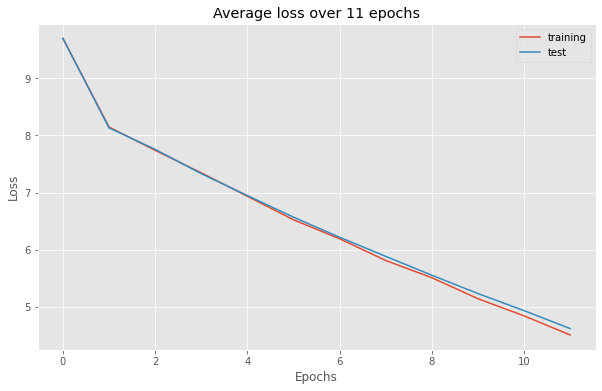

Autoencoded Tweet (Training Sample):
Input: <Start> tell iran to let our christian pastor go and i mean right now . if they dont , there will be hell to pay . <End>
Output: obama obama , stop us own to . to they will they to . we we will want it will be a to be . <End>

Autoencoded Tweet (Training Sample):
Input: <Start> have a great , but very reflective , presidents day ! <End>
Output: a a great job and great good and and ! ! <End>

Autoencoded Tweet (Test Sample):
Input: <Start> a rods appeal will go nowhere . he will get a long suspension . good for the @yankees . and sends strong message to @mlb players . <End>
Output: a rod friend and be to and he is be a great and . he luck a @yankees . he will them and to be . . <End>

Autoencoded Tweet (Test Sample):
Input: <Start> i am on @foxandfriends enjoy ! <End>
Output: i will on @foxandfriends ! ! <End>



In [ ]:
TwitterAE = AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)
trainModel(TwitterAE,loss_function=tf.keras.losses.SparseCategoricalCrossentropy(), name="TwitterAE")
TwitterAE.save_weights("drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/model_weights_stacked_bi/TwitterAE")

In [ ]:
TwitterAE_2 = AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)
TwitterAE_2.compile()


In [ ]:
TwitterAE_2.load_weights("drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/model_weights/TwitterAE")

In [ ]:
# TwitterAE_2.load_weights("drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/model_weights/TwitterAE")
# trainModel(TwitterAE_2,loss_function=tf.keras.losses.SparseCategoricalCrossentropy(), name="TwitterAE")
# TwitterAE_2.save_weights("drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/model_weights_2/TwitterAE_2")

In [ ]:
# model = tf.keras.models.load_model(filepath="drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/model")
# trainModel(model,loss_function=tf.keras.losses.SparseCategoricalCrossentropy(), name="TwitterAE")
# tf.keras.models.save_model(model=TwitterAE, filepath="drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/model", save_traces=False)

## **GAN**

In [ ]:
train_dataset_GAN = train_dataset_input
train_dataset_GAN = train_dataset_GAN.map(lambda x: tf.squeeze(TwitterAE_2.Encoder(tf.expand_dims(x, axis=0)))) # maybe replace using tqdm
train_dataset_GAN = train_dataset_GAN.cache().batch(50).prefetch(tf.data.experimental.AUTOTUNE)



In [ ]:
for i in train_dataset_input.take(1):
  print(i)

tf.Tensor(
[   2   84   41 1430   11  110   10   67  961 5541    1   55   27   50
  285   78   11  110   10   67 3710    1    3], shape=(23,), dtype=int32)


In [ ]:
for i in train_dataset_GAN:
  print(i.shape)

(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)
(50, 600)


### ResNet

The Generator and Discriminator are built using a ResNet Architecture.

In [ ]:
class ResidualBlock(Model):

  def __init__(self, architecture):
    """Initialize a Residual Block with two kernel_size x kernel_size convolutional layers.

    Arguments:
    """
    # use the keyword super to allow our network to access the init() form the keras Layer class
    super(ResidualBlock, self).__init__()

    # define set of layers
    # Maybe BatchNorm???????????????????????????????????????????????????????????
    if architecture == "Discriminator":
      self.ResBlockLayers = [tfkl.Dense(100, activation="relu",     
                                        kernel_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01),
                                        bias_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01)),
                            tfkl.Dense(100, activation=None,  
                                        kernel_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01),
                                        bias_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01))]
    else:
      self.ResBlockLayers = [tfkl.Dense(100, activation="relu"), tfkl.Dense(100, activation=None)]
    
  # Use the decorator @tf.function to speed up the model call. 
  # Furthermore, we pass a training flag such that we only use our regularization methods during training. 
  @tf.function 
  def call(self, x):
      """Activate our ResidualBlock, by propagating the input through the ResBlock layer by layer

      Arguments:
        x (Tensor): Tensor containing the input to our ResBlock
        training (Boolean): Indicates whether regularization methods should be used or not when calling the ResBlock 

      Returns:
        x (Tensor): Tensor containing the activation of our ResBlock
      """

      y = x

      for layer in self.ResBlockLayers:
        y = layer(y)
      
      # here we apply the pointwise addition of the original input to the ResBlock's output
      y = x+y

      # after the addition we apply the activation function
      return tf.nn.relu(y)

### Generator

In [ ]:
class Generator(Model):

  def __init__(self):
    
    super(Generator, self).__init__()

    self.generator_layers = [ResidualBlock(architecture="Generator") for _ in range(40)]
    self.generator_layers.append(tfkl.Dense(600, activation=None))

  @tf.function
  def call(self, x): 

    for layer in self.generator_layers:
      x = layer(x)
    return x

### Discriminator

In [ ]:
class Discriminator(Model):

  def __init__(self):
    
    super(Discriminator, self).__init__()

    self.discriminator_layers = [ResidualBlock(architecture="Generator") for _ in range(40)]
    # self.discriminator_layers.insert(0, tfkl.Dense(100, activation=None,  
    #                                                kernel_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01),
    #                                                bias_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01)))
    self.discriminator_layers.insert(0, tfkl.Dense(100, activation=None))
    self.discriminator_layers.append(tfkl.Dense(1, activation=None))

  @tf.function
  def call(self, x): 

    for layer in self.discriminator_layers:
      x = layer(x)
    return x

### WGANA Loss


In [ ]:
def discriminator_loss(real_tweet, fake_tweet):
  """
  Wasserstein loss for the discriminator: Sum of losses for real and fake 
  images which are just the mean for all discriminator outputs of the respective 
  group (negative mean for the real images).

  output_real_image:  classifications of one batch of real images
  output_fake_image:  classifications of one batch of fake images
  """
  loss_real = - tf.reduce_mean(real_tweet)
  loss_fake = tf.reduce_mean(fake_tweet)

  return loss_real + loss_fake

def generator_loss(fake_tweet):
  """
  Wasserstein loss for the generator is the mean of the output multiplied by -1.
  
  output_fake_image:  classifications of one batch of fake images
  """

  loss_fake = - tf.reduce_mean(fake_tweet)

  return loss_fake

## **Visualization**

In [ ]:
def visualize_GAN(discriminator, fixed_input, random_input, train_losses_generator, train_losses_discriminator, num_epochs):
  """Visualize performance of the Generator by feeding 10 predefined random noise vectors through it.
  Additionally title each plot with the prediction of the Discriminator --> Fake or Real
  
  Arguments:
    noise_list (list): list containing the predefined random vectors 
  """ 
  # Print: Real Tweet + Prediction?, Print: Generated Tweet + Prediction
  # print losses

  print() #GAN Klasse?
  print("Generated Tweets:")
  print(f"From Fixed Vector: {' '.join([word2vec_model.wv.index2word[i.numpy()[0] -1] for i in TwitterAE_2.Decoder.inference_mode(states=fixed_input[0], training=False) if i.numpy()[0] != 0])}")
  print(f"From Fixed Vector: {' '.join([word2vec_model.wv.index2word[i.numpy()[0] -1] for i in TwitterAE_2.Decoder.inference_mode(states=fixed_input[1], training=False) if i.numpy()[0] != 0])}")
  #print(f"Prediction from Discriminator: {discriminator(fixed_input).numpy()[0][0]>0.5}")
  print()
  print(f"From Random Vector: {' '.join([word2vec_model.wv.index2word[i.numpy()[0] -1] for i in TwitterAE_2.Decoder.inference_mode(states=random_input[0], training=False) if i.numpy()[0] != 0])}")
  print(f"From Random Vector: {' '.join([word2vec_model.wv.index2word[i.numpy()[0] -1] for i in TwitterAE_2.Decoder.inference_mode(states=random_input[1], training=False) if i.numpy()[0] != 0])}")
  #print(f"Prediction from Discriminator: {discriminator(random_input).numpy()[0][0]>0.5}")


  plt.style.use('ggplot')

  fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))
  ax1.plot(train_losses_generator, label='Generator')
  ax1.plot(train_losses_discriminator, label='Discriminator')
  ax1.set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')
  ax1.legend()

  plt.show()

### **Training**

### Function for Gradient Penalty that replaces the weight clipping that is used to enforce lipschitz continuity

In [ ]:
# def compute_grad_penalty(critic, real_data, fake_data):
#     B = real_data.size(0)
#     alpha = torch.FloatTensor(np.random.random((B, 1)))
#     if args.cuda:
#         alpha = alpha.cuda()
#     sample = alpha*real_data + (1-alpha)*fake_data
#     sample.requires_grad_(True)
#     score = critic(sample)

#     outputs = torch.FloatTensor(B, args.latent_dim).fill_(1.0)
#     outputs.requires_grad_(False)
#     if args.cuda:
#         outputs = outputs.cuda()
#     grads = autograd.grad(
#         outputs=score,
#         inputs=sample,
#         grad_outputs=outputs,
#         create_graph=True,
#         retain_graph=True,
#         only_inputs=True
#     )[0]
#     #grads = grads.view(B, -1)
#     grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()
#     return grad_penalty


#     # lambda = 10
#     # alpha = 

#     for i, device in enumerate(DEVICES_B):
#     with tf.device(device):
#         real_data = tf.concat([all_real_data_splits[i], all_real_data_splits[len(DEVICES_A)+i]], axis=0)
#         fake_data = tf.concat([fake_data_splits[i], fake_data_splits[len(DEVICES_A)+i]], axis=0)
#         labels = tf.concat([
#             labels_splits[i], 
#             labels_splits[len(DEVICES_A)+i],
#         ], axis=0)
#         alpha = tf.random_uniform(
#             shape=[BATCH_SIZE/len(DEVICES_A),1], 
#             minval=0.,
#             maxval=1.
#         )
#         differences = fake_data - real_data
#         interpolates = real_data + (alpha*differences)
#         gradients = tf.gradients(Discriminator(interpolates, labels)[0], [interpolates])[0]
#         slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
#         gradient_penalty = 10*tf.reduce_mean((slopes-1.)**2)
#         disc_costs.append(gradient_penalty)

In [ ]:
@tf.function() 
def gradient_penalty(discriminator, real_tweet, generated_tweet):

  alpha = tf.random.uniform(shape=[real_tweet.shape[0], 1], minval=0, maxval=1)

  interpolate = alpha*real_tweet + (1-alpha)*generated_tweet # Maybe interpolate like real authors

  output = discriminator(interpolate)

  gradients = tf.gradients(output, interpolate)

  gradient_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients)))

  penalty = 10*tf.reduce_mean((gradient_norm-1.)**2)

  return penalty

In [ ]:
@tf.function()  
def train_step_GAN(generator, discriminator, train_data, optimizer_generator, optimizer_discriminator, train_generator):
  """Perform a training step for a given Network by
  1. Generating Random noise for the Generator
  2. Feeding the noise through the Generator to create Fake Images for the Discriminator 
  3. Feeding the Fake Images / Train Images through the Discriminator 
  4. Calculating the loss for the Disriminator and the Generator 
  5. Performing Backpropagation and Updating the trainable variables with the calculated gradients, using the specified optimizer 

  Arguments:
    training_images (EagerTensor): Tensor containing the training data 
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
 
  Returns:
    loss_from_generator, loss_from_discriminator (Tupel): Tupel containing the loss of both the Generator and Discriminator
  """
  # 1.
  noise = tf.random.normal([train_data.shape[0], 100]) # evtl multivariatenormaltril/diag

  # Two Gradient Tapes, one for the Discriminator and one for the Generator 
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
      # 2.
      generated_tweet = generator(noise)

      # 3.
      real = discriminator(train_data)
      fake = discriminator(generated_tweet)

      # 4.
      loss_from_generator = generator_loss(fake)
      loss_from_discriminator = discriminator_loss(real, fake) + gradient_penalty(discriminator=discriminator, real_tweet=train_data, generated_tweet=generated_tweet)

  # 5.

  gradients_from_discriminator = discriminator_tape.gradient(loss_from_discriminator, discriminator.trainable_variables)
  # We update the generator once for ten updates to the discriminator
  print(train_generator)
  if train_generator:
    print("Achso Eingerückt?")
    gradients_from_generator = generator_tape.gradient(loss_from_generator, generator.trainable_variables)
    optimizer_generator.apply_gradients(zip(gradients_from_generator, generator.trainable_variables))
  optimizer_discriminator.apply_gradients(zip(gradients_from_discriminator, discriminator.trainable_variables))

  return loss_from_generator, loss_from_discriminator

In [ ]:
def train_GAN(generator, discriminator, num_epochs=50, running_average_factor=0.95, learning_rate=0.0001):
  """Function that implements the training algorithm for our Gan.
  Prints out useful information and visualizations per epoch.

  Arguments:
    num_epochs (int): Defines the amount of epochs the training is performed
    running_average_factor (float): To be used factor for computing the running average of the trainings loss, per default set to 0.95
  """ 
  tf.keras.backend.clear_session()
  optimizer_generator=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate=learning_rate)

  fixed_generator_input_1 = tf.random.normal([1, 100])
  fixed_generator_input_2 = tf.random.normal([1, 100])

  # Initialize lists for later visualization.
  train_losses_generator = []
  train_losses_discriminator = []

  train_generator = False

  for epoch in range(num_epochs):

      start = time.time()
      running_average_gen = 0
      running_average_disc = 0

      for batch_no, input in enumerate(train_dataset_GAN):

          train_generator = False
          if batch_no % 10 == 0:
            train_generator = True

          gen_loss, disc_loss = train_step_GAN(generator, discriminator, train_data=input, optimizer_generator=optimizer_generator, optimizer_discriminator=optimizer_discriminator, train_generator=train_generator)
          #print(gen_loss)
          #print(disc_loss)
          running_average_gen = running_average_factor * running_average_gen + (1 - running_average_factor) * gen_loss
          running_average_disc = running_average_factor * running_average_disc + (1 - running_average_factor) * disc_loss
      train_losses_generator.append(float(running_average_gen))
      train_losses_discriminator.append(float(running_average_disc))

      #clear_output()
      print(f'Epoch: {epoch+1}')      
      print()
      print(f'This epoch took {timing(start)} seconds')
      print()
      print(f'The current generator loss: {round(train_losses_generator[-1], 4)}')
      print()
      print(f'The current discriminator loss: {round(train_losses_discriminator[-1], 4)}')
      print()

      random_generator_input_1 = tf.random.normal([1, 100])
      random_generator_input_2 = tf.random.normal([1, 100])
      visualize_GAN(discriminator, (generator(fixed_generator_input_1), generator(fixed_generator_input_2)), (generator(random_generator_input_1), generator(random_generator_input_2)), train_losses_generator, train_losses_discriminator, epoch+1)


In [ ]:
GAN_Generator = Generator()
GAN_Discriminator = Discriminator()



True
Achso Eingerückt?
True
Achso Eingerückt?
False
False
Epoch: 1

This epoch took 177.7131 seconds

The current generator loss: 8.792

The current discriminator loss: 2767.2898


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


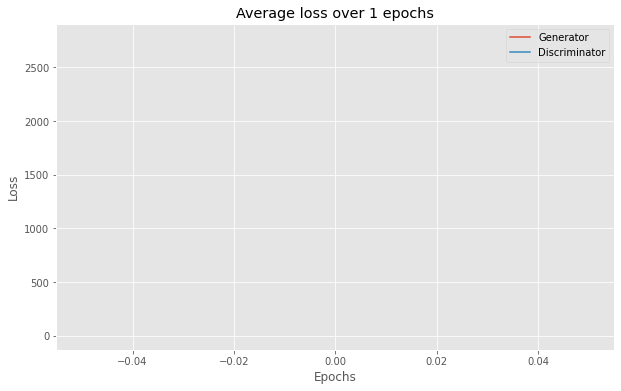

Epoch: 2

This epoch took 12.0879 seconds

The current generator loss: 22.3663

The current discriminator loss: 751.9374


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


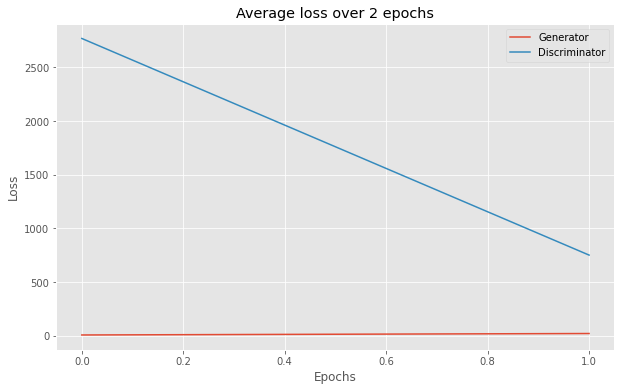

Epoch: 3

This epoch took 11.8976 seconds

The current generator loss: 12.528

The current discriminator loss: 1150.1711


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


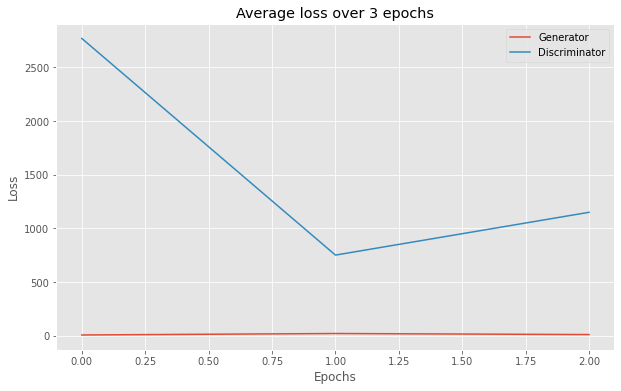

Epoch: 4

This epoch took 11.9973 seconds

The current generator loss: 2.5562

The current discriminator loss: 74.6318


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


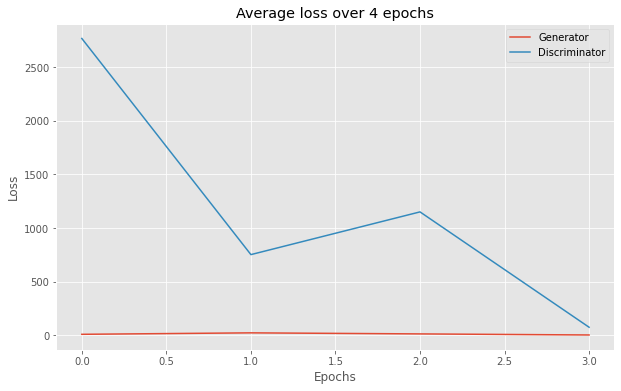

Epoch: 5

This epoch took 12.0915 seconds

The current generator loss: 1.4176

The current discriminator loss: 45.9436


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


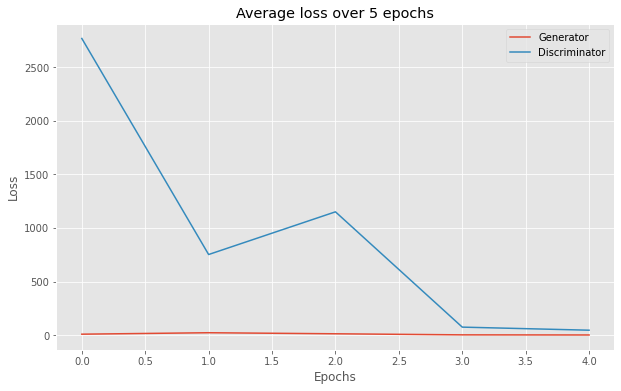

Epoch: 6

This epoch took 11.9997 seconds

The current generator loss: 0.2292

The current discriminator loss: 56.5253


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


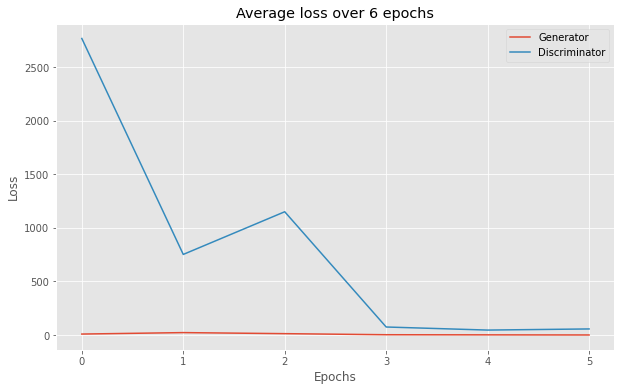

Epoch: 7

This epoch took 12.0876 seconds

The current generator loss: 0.6813

The current discriminator loss: 29.7401


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


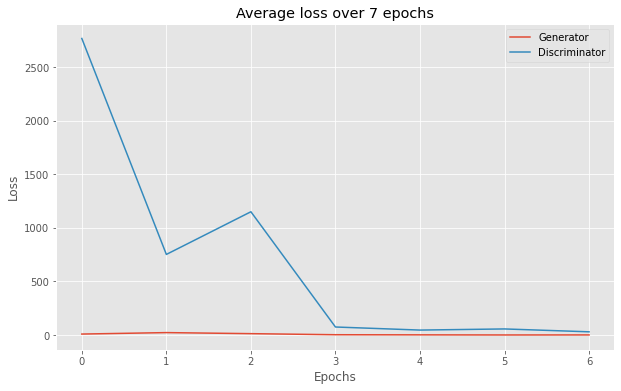

Epoch: 8

This epoch took 12.0021 seconds

The current generator loss: -0.5411

The current discriminator loss: 31.4067


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


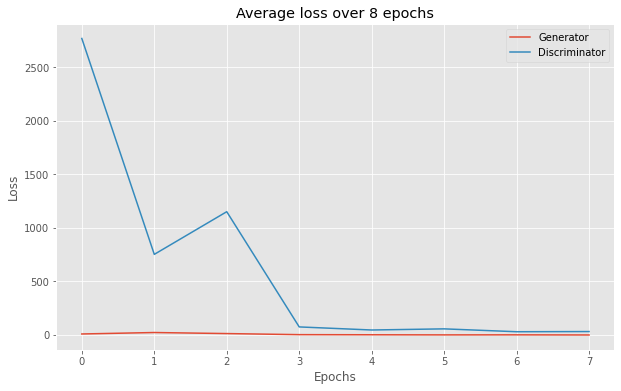

Epoch: 9

This epoch took 12.1448 seconds

The current generator loss: -0.6832

The current discriminator loss: 133.961


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


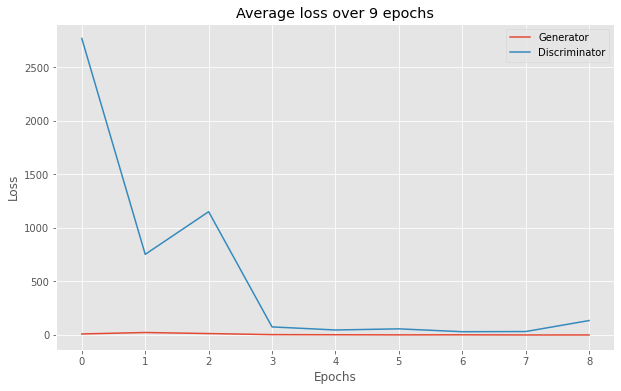

Epoch: 10

This epoch took 12.0706 seconds

The current generator loss: -1.9115

The current discriminator loss: 16.371


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


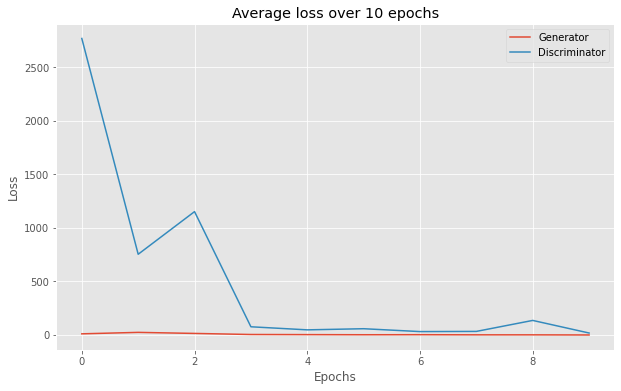

Epoch: 11

This epoch took 12.2098 seconds

The current generator loss: -1.2319

The current discriminator loss: 11.2773


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


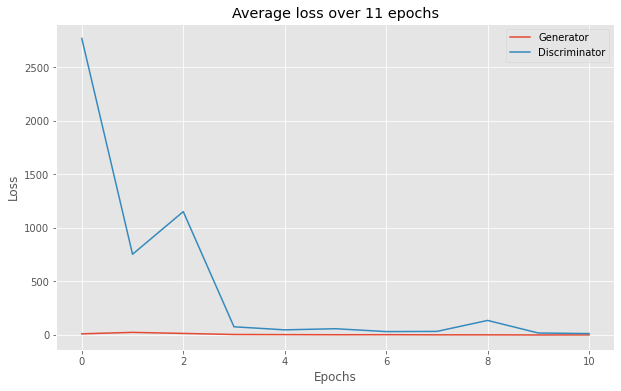

Epoch: 12

This epoch took 12.097 seconds

The current generator loss: -1.2825

The current discriminator loss: 0.5951


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


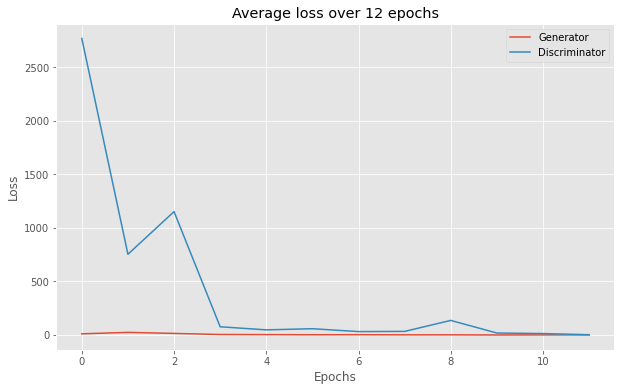

Epoch: 13

This epoch took 12.2358 seconds

The current generator loss: -1.125

The current discriminator loss: 11.9753


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


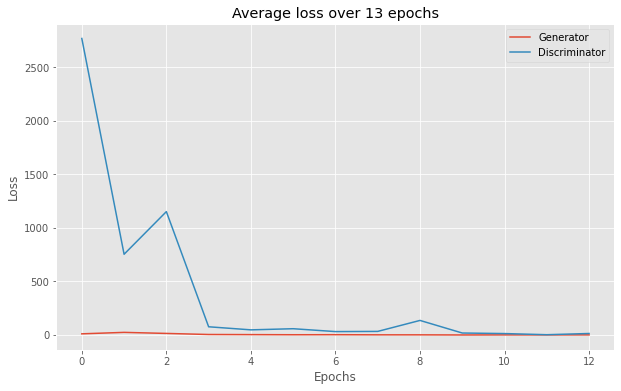

Epoch: 14

This epoch took 12.0556 seconds

The current generator loss: -0.391

The current discriminator loss: -0.2273


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


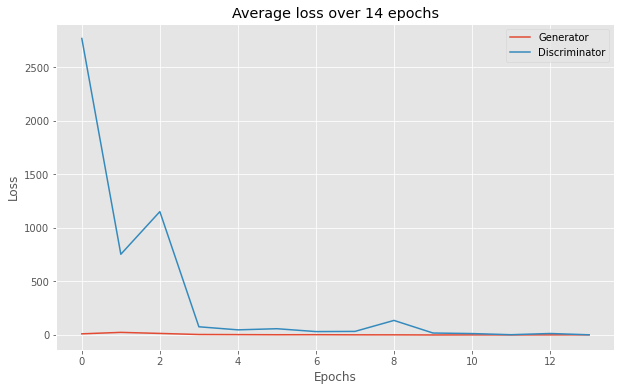

Epoch: 15

This epoch took 12.1376 seconds

The current generator loss: -0.3918

The current discriminator loss: -0.5339


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


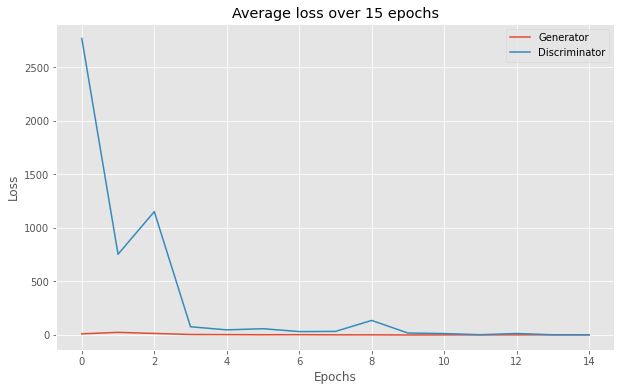

Epoch: 16

This epoch took 12.0933 seconds

The current generator loss: -0.9131

The current discriminator loss: 0.7103


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


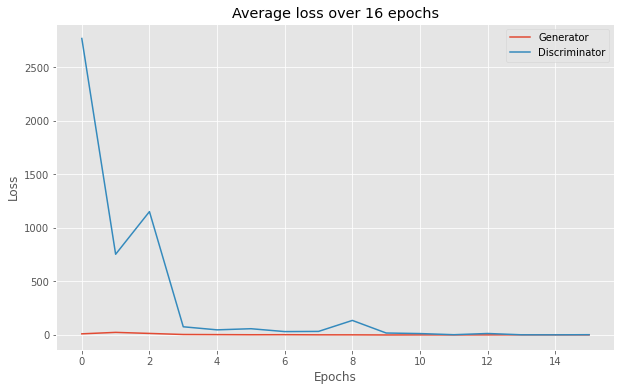

Epoch: 17

This epoch took 12.0655 seconds

The current generator loss: -1.5043

The current discriminator loss: 0.3035


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


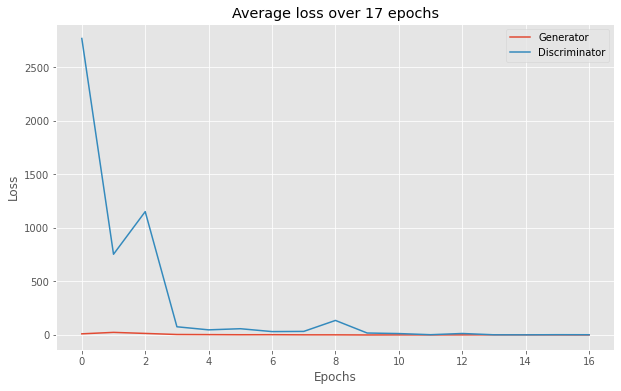

Epoch: 18

This epoch took 12.0672 seconds

The current generator loss: -1.3324

The current discriminator loss: -0.0752


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


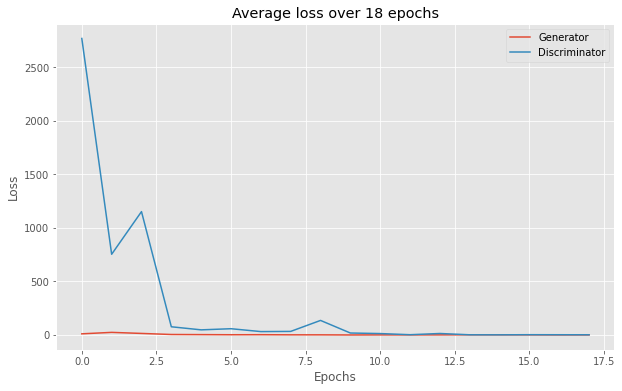

Epoch: 19

This epoch took 12.1398 seconds

The current generator loss: -1.0682

The current discriminator loss: -0.2053


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


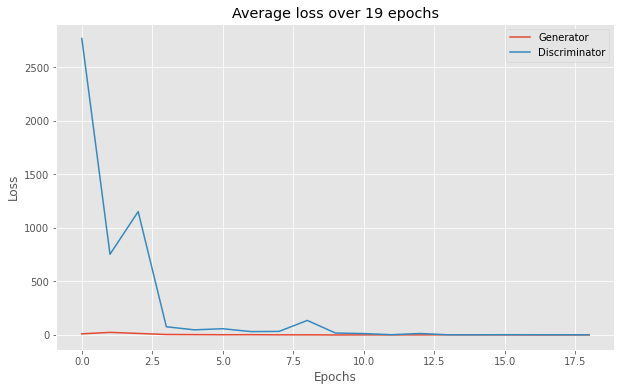

Epoch: 20

This epoch took 12.1648 seconds

The current generator loss: -1.523

The current discriminator loss: 1.7403


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


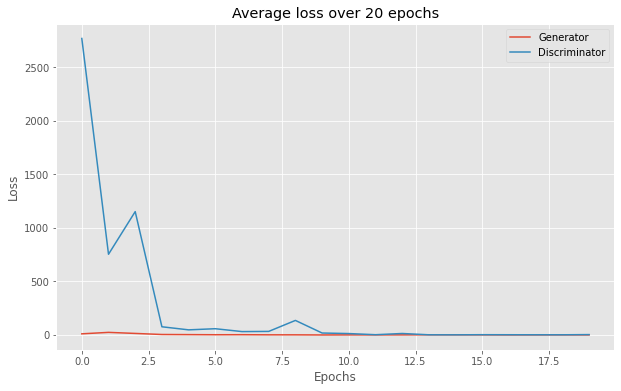

Epoch: 21

This epoch took 12.0804 seconds

The current generator loss: -1.7156

The current discriminator loss: 0.3294


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


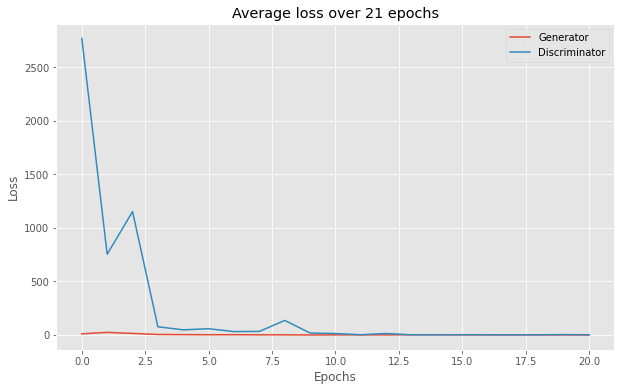

Epoch: 22

This epoch took 12.4184 seconds

The current generator loss: -1.3517

The current discriminator loss: -0.1313


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


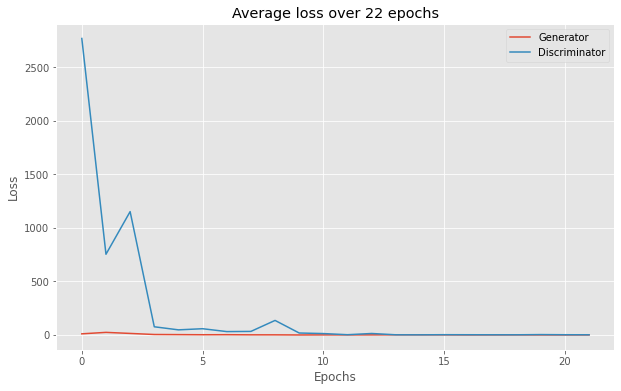

Epoch: 23

This epoch took 12.2005 seconds

The current generator loss: -1.4822

The current discriminator loss: 0.5267


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


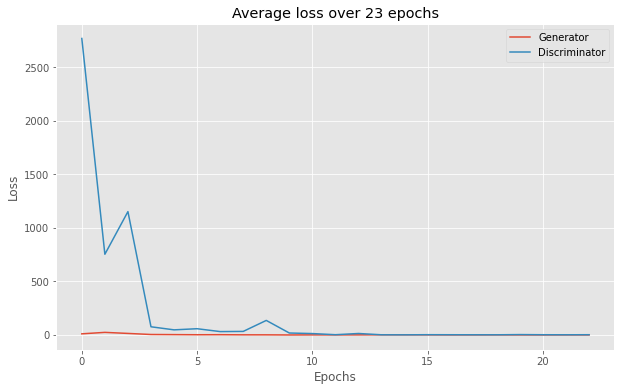

Epoch: 24

This epoch took 12.2761 seconds

The current generator loss: -1.6045

The current discriminator loss: -0.1629


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


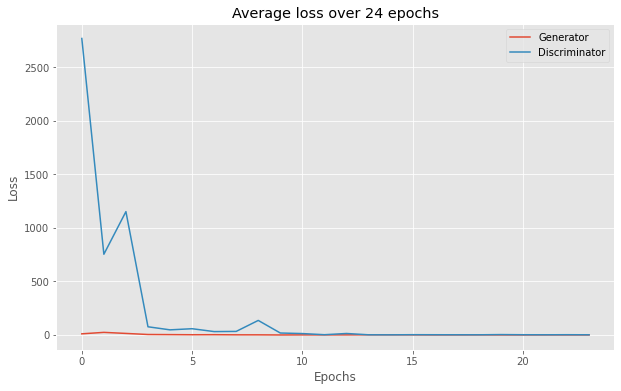

Epoch: 25

This epoch took 12.0451 seconds

The current generator loss: -0.8072

The current discriminator loss: -0.6351


Generated Tweets:
From Fixed Vector: 
From Fixed Vector: 

From Random Vector: 
From Random Vector: 


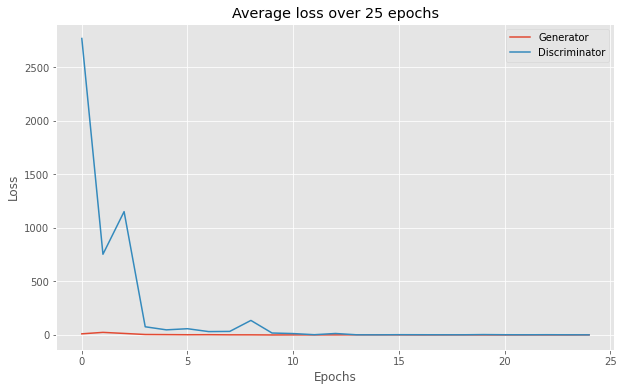

Epoch: 26

This epoch took 12.3148 seconds

The current generator loss: -1.5248

The current discriminator loss: 2.3475


Generated Tweets:
From Fixed Vector: to obama : my brother has been given a great job he did . he is a special prosecutor , who has been treated me unfairly . i will be presenting <End>
From Fixed Vector: 

From Random Vector: my first : “ trust : trump is a spy and , golf course in doonbeg . i love it is that it is ! <End>
From Random Vector: just out : donald trump a wonderful letter of your word . it is often that you can do it . dwight . i think it was <End>


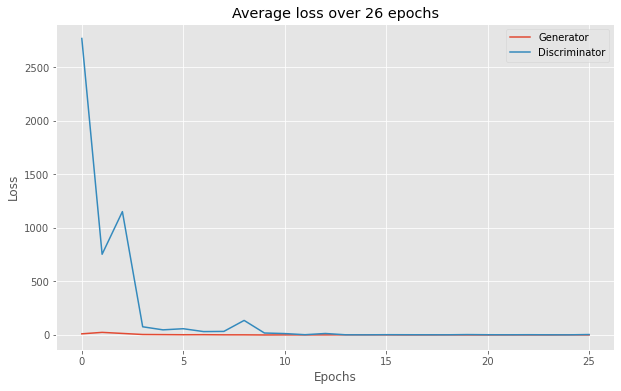

Epoch: 27

This epoch took 12.172 seconds

The current generator loss: 0.1578

The current discriminator loss: -0.4183


Generated Tweets:
From Fixed Vector: to obama please inform him on his . g . he will bring his jet jet , and , his friend , he has a great supporter ! <End>
From Fixed Vector: 

From Random Vector: most respected : jeb did a small fraction of money to make me in my opinion . i know you are doing what i am right . i am not a fan of <End>
From Random Vector: from : my husband called to china make it sound like it is a great book , which i am very proud of you . no talent ! <End>


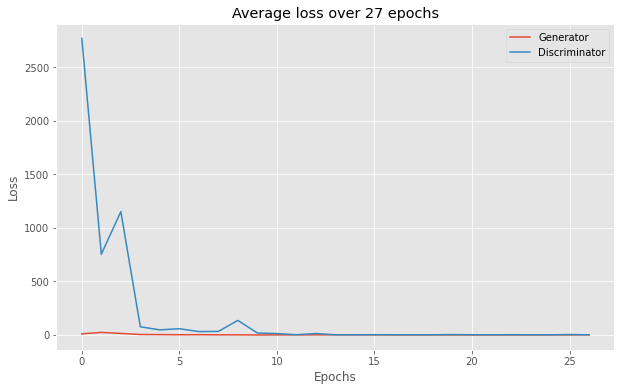

Epoch: 28

This epoch took 12.1284 seconds

The current generator loss: -0.5879

The current discriminator loss: -0.0655


Generated Tweets:
From Fixed Vector: when youre sending our troops killed <num> years ago . this is president ! <End>
From Fixed Vector: prayer only only short term : time when talking peace in the world . they must abandon their resistance leadership ! <End>

From Random Vector: no question of obamas speech : make a deal with china . i will make a deal ! <End>
From Random Vector: time that should release transcripts you have a special interest in pennsylvania . <End>


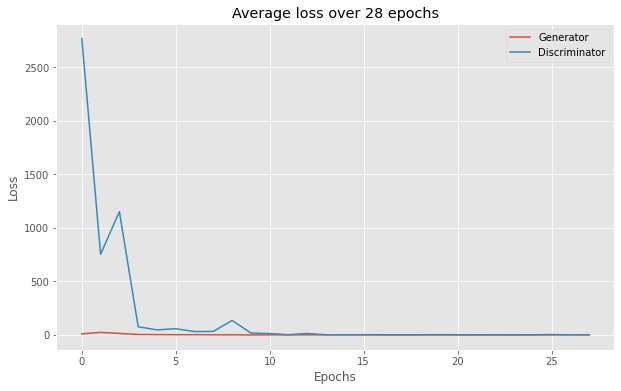

Epoch: 29

This epoch took 12.1926 seconds

The current generator loss: -0.2066

The current discriminator loss: 0.7188


Generated Tweets:
From Fixed Vector: no matter who : freedom women would be saved the orlando in august ? <End>
From Fixed Vector: blue wants to pay attention : no president obama , who will be broken ! witch hunt ! <End>

From Random Vector: no matter who : freedom women would be saved the lives of innocent babies . <End>
From Random Vector: no matter gun free air travel to be stopped . this is just fine ! <End>


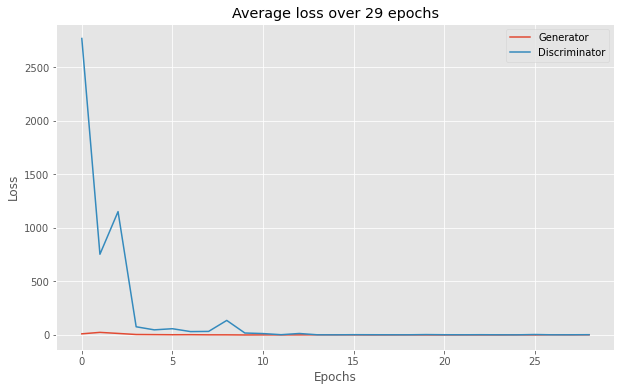

Epoch: 30

This epoch took 12.3362 seconds

The current generator loss: -0.416

The current discriminator loss: -0.2724


Generated Tweets:
From Fixed Vector: no happy thanksgiving is that in federal government this should be fired for your president ! <End>
From Fixed Vector: no happy to young young girl they cant even government ? ? ! ! <End>

From Random Vector: no wh did you pay from troops troops from her home of her ! <End>
From Random Vector: have a government government got caught . this should never happen to be . <End>


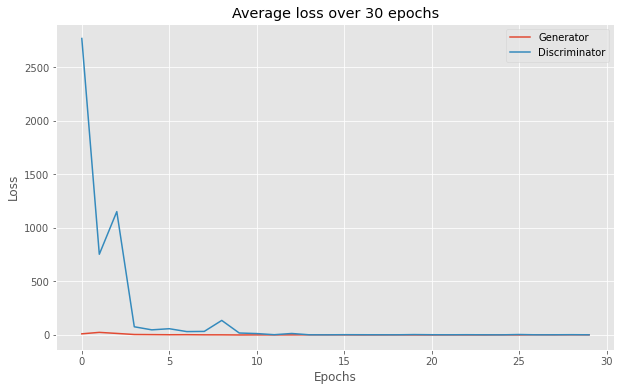

Epoch: 31

This epoch took 12.1209 seconds

The current generator loss: -0.4004

The current discriminator loss: -0.3723


Generated Tweets:
From Fixed Vector: general we should be running for president of the free speech . no longer be good ! <End>
From Fixed Vector: “ these problems problems out : we had a massive abuse . we have to do this ! <End>

From Random Vector: “ @realdonaldtrump no more testing deals with the american public . ” – think <End>
From Random Vector: no political shot shot to young young protesters . god bless the people of our country ! <End>


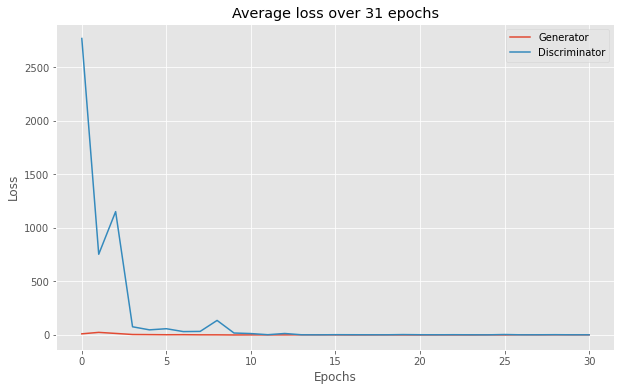

Epoch: 32

This epoch took 12.1326 seconds

The current generator loss: 0.593

The current discriminator loss: 0.181


Generated Tweets:
From Fixed Vector: general we should have told a free speech for our embassy . s . president trump never stopped ! <End>
From Fixed Vector: “ confidence confidence : the chinese government is doing its own . ” the united states in china . ” <End>

From Random Vector: general we have already killed negotiating in a long time ago . when i told them to iran , in order ! <End>
From Random Vector: trump should be running against isis , and the first time in a long time . nice ! <End>


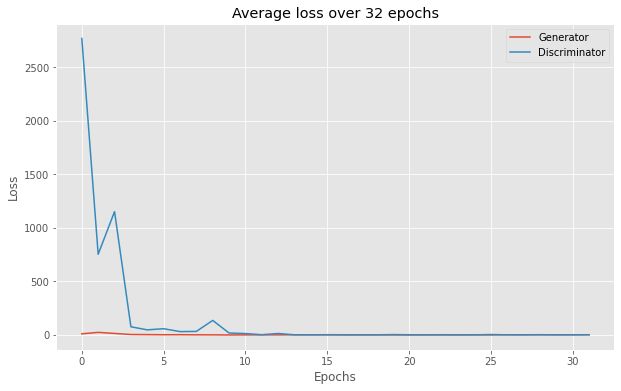

Epoch: 33

This epoch took 11.9957 seconds

The current generator loss: 0.778

The current discriminator loss: 0.0855


Generated Tweets:
From Fixed Vector: that young girl never had freedom room in our society . should be ashamed of them ! <End>
From Fixed Vector: “ <num> times larger deal : the chinese virus is doing the right to the world . ” via @breitbartnews <End>

From Random Vector: that my administration has called assault america . now it is time ! <End>
From Random Vector: that failing @nytimes has become to save our great defense of defense , defense john roberts , and so ! <End>


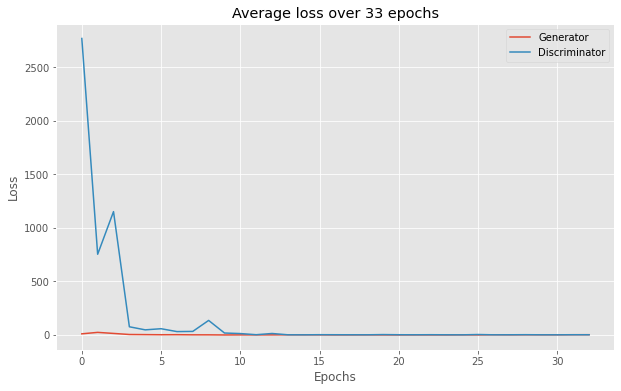

Epoch: 34

This epoch took 11.9855 seconds

The current generator loss: 0.5522

The current discriminator loss: -0.4132


Generated Tweets:
From Fixed Vector: no president obamas day , when will defeat isis and , then put it out ? this place ! <End>
From Fixed Vector: “ <num> years to americas confidence that ” is just beginning from the beginning . they are in the place ! <End>

From Random Vector: a radical left that : we were led into the ground . ” when i told you so badly . <End>
From Random Vector: many more time to isis against trump national doral . they will do it , i will be great ! <End>


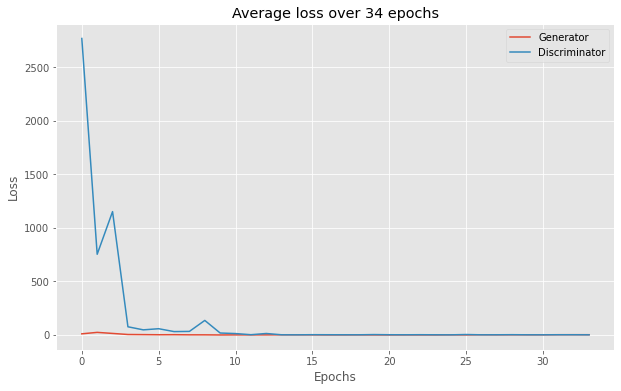

Epoch: 35

This epoch took 12.1276 seconds

The current generator loss: -0.1524

The current discriminator loss: -0.1897


Generated Tweets:
From Fixed Vector: “ you have been immediately hit isis , isis and now theyre there a coup president ! ” <End>
From Fixed Vector: <num> “ its not even more testing than testing . ” they are very much for them ! <End>

From Random Vector: time for the president obama years now being is doing a great job ! <End>
From Random Vector: people watched a big mistake in order to get their money ( or not ) . c . thank you <End>


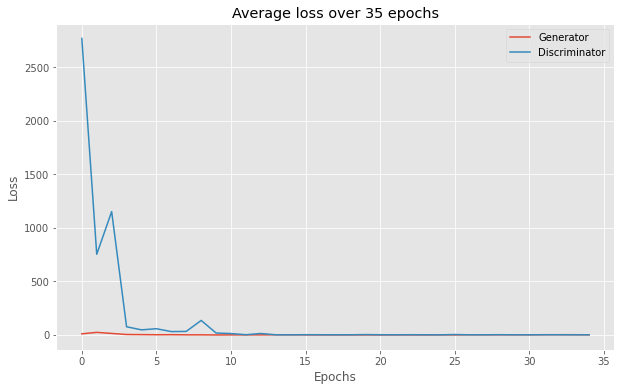

Epoch: 36

This epoch took 11.9416 seconds

The current generator loss: 0.2654

The current discriminator loss: -0.6985


Generated Tweets:
From Fixed Vector: even though my decision and run for president of china is being told . this terrible situation for president ! <End>
From Fixed Vector: just out of president . obama care more you have the last <num> years . all time ! #maga <End>

From Random Vector: were going to fire robert gates a big hero in new york . he doesnt do it . <End>
From Random Vector: let the failing new york times if he has to be president for president . this is a joke ! <End>


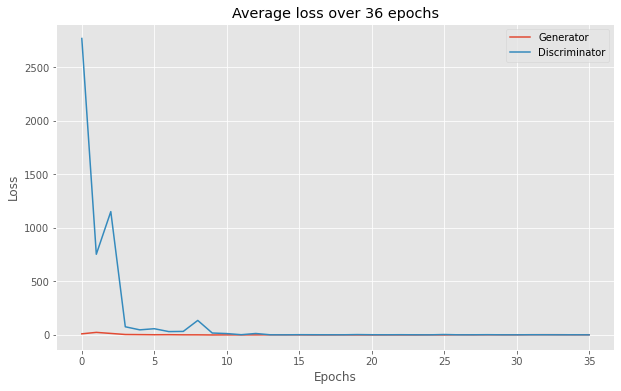

Epoch: 37

This epoch took 12.0158 seconds

The current generator loss: 2.1253

The current discriminator loss: -0.3463


Generated Tweets:
From Fixed Vector: so called small protest in chicago is trying to use the words to watch . john mccain couldnt ! <End>
From Fixed Vector: by president , # <num> right right now . ” – the “ light ” get out of the <num> ! <End>

From Random Vector: even greater crowd of the people who love their country . when you look at the tea party , <num> <End>
From Random Vector: even president obamas day , and look at the same time not make america rich again . order watch <End>


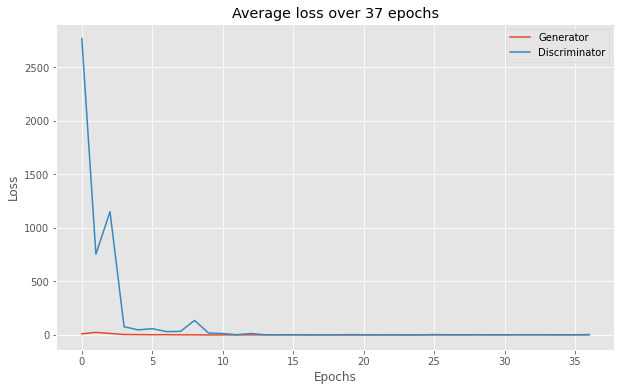

Epoch: 38

This epoch took 11.88 seconds

The current generator loss: -0.0701

The current discriminator loss: -0.3699


Generated Tweets:
From Fixed Vector: one shows that my life is shot up from heaven , and then dropped out of indiana ! <End>
From Fixed Vector: . @petehegseth the president about keeping changing reasons is just the beginning . its time to start thinking ! <End>

From Random Vector: first time in the senate that mitt should spend more time in many years , and , others ! <End>
From Random Vector: a job report . you just cant stand the ship of the big league . big league financially ! big <End>


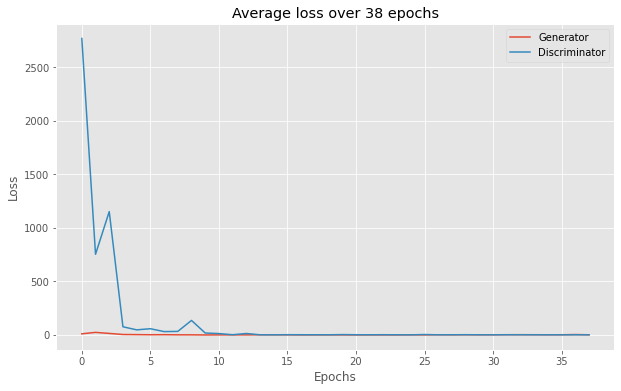

Epoch: 39

This epoch took 11.8835 seconds

The current generator loss: 0.3845

The current discriminator loss: -0.3787


Generated Tweets:
From Fixed Vector: watch me and @paulryanvp on china and medicare . if you run for president in <num> years . #celebapprentice <End>
From Fixed Vector: terrible story in america is what a terrible job . how many people want to run in <num> ? #debates <End>

From Random Vector: one shows that our nation has just hit me to get out in business . ” = <num> % ! <End>
From Random Vector: time ago to the @whitehouse people start saying that im fighting in washington , d . c . ) . <End>


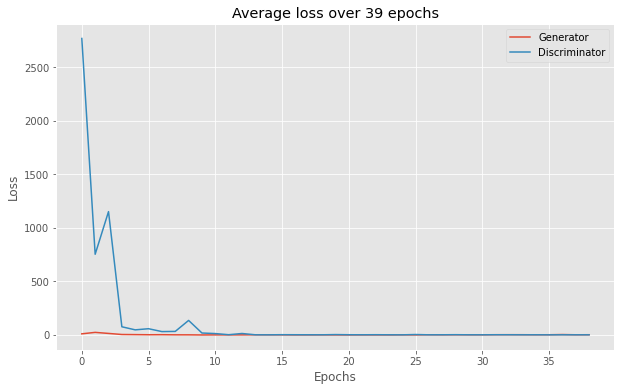

Epoch: 40

This epoch took 12.1055 seconds

The current generator loss: 0.036

The current discriminator loss: -0.1768


Generated Tweets:
From Fixed Vector: one thing has turned out to watch and barack obama on wednesday . dont worry , i will always stand . <End>
From Fixed Vector: for purposes approval rating . the good thing to do the same americans are leaving . massive numbers <End>

From Random Vector: melania and have been the most peaceful : things in <num> years . you have my vote for chris . <End>
From Random Vector: @thefamilyleader , the people are working hard against me today , “ john president is doing in many years . ” <End>


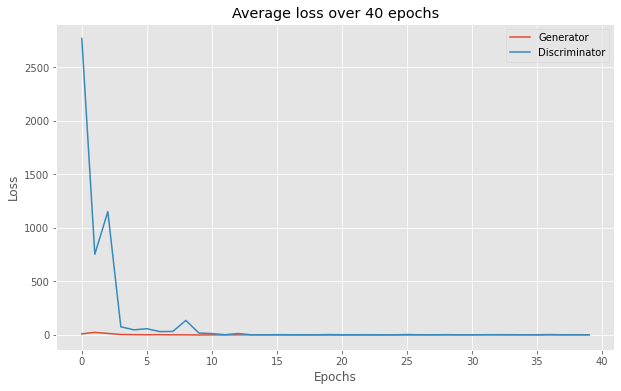

Epoch: 41

This epoch took 11.964 seconds

The current generator loss: -0.6551

The current discriminator loss: -0.4588


Generated Tweets:
From Fixed Vector: one thing that has received freedom of my speech is not enough . lets see the answers for justice department . <End>
From Fixed Vector: for @gop mcconnell never give up the big . in <num> years , why do you have ? ? <End>

From Random Vector: every time i have treated in washington ny times trying to get a comeback , not a fan ! <End>
From Random Vector: re : i am the working situation situation this very good ( very ) promising <End>


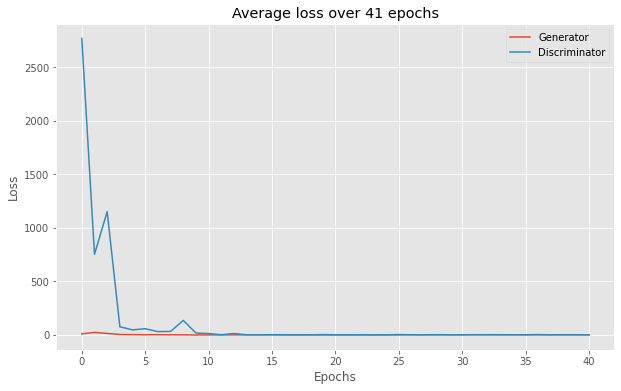

Epoch: 42

This epoch took 12.0607 seconds

The current generator loss: 0.2981

The current discriminator loss: 0.4702


Generated Tweets:
From Fixed Vector: one thing has now officially that my administration is going to be released from john mccain . mccain . <End>
From Fixed Vector: for president ! ? maybe my opinion have accomplished more than ever before . at the clip ! <End>

From Random Vector: time for president obama , i will see what <num> years ago . what a man is doing this ! <End>
From Random Vector: president , @mittromney is looking for telling to change the words on earth . watch and be careful to watch ! <End>


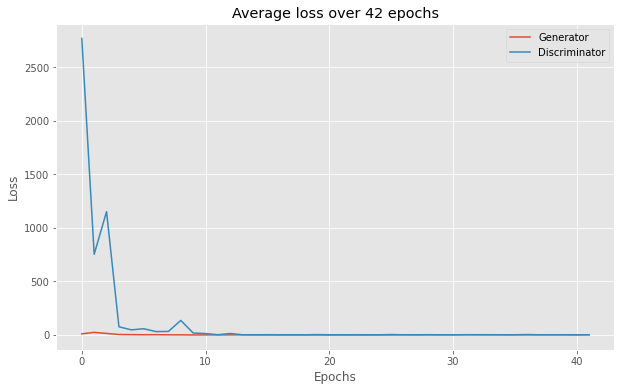

Epoch: 43

This epoch took 11.8837 seconds

The current generator loss: 1.7748

The current discriminator loss: -0.2275


Generated Tweets:
From Fixed Vector: one year ago must watch , the question of question : pain on many years . watch politicians ! <End>
From Fixed Vector: for purposes approval rating . the good thing to do is in their massive tax increase in all <End>

From Random Vector: time for those who have met me to get out on @foxnews and will be another day ! <End>
From Random Vector: glad is the beginning of presidential election . its time to get tough and smart answers for his terrible . <End>


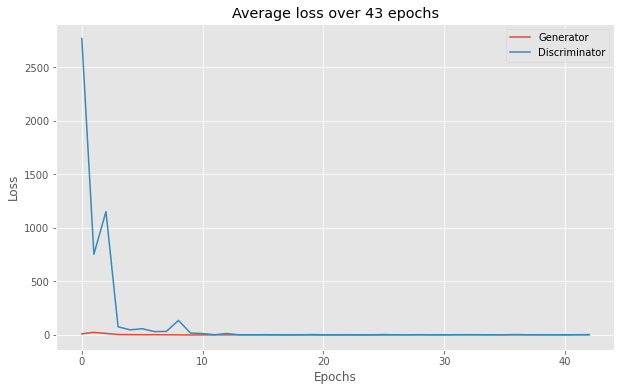

Epoch: 44

This epoch took 11.9049 seconds

The current generator loss: -0.2734

The current discriminator loss: -0.2183


Generated Tweets:
From Fixed Vector: once again obama , called me at <num> : <num> p . m . is concerned about it and make america great again <End>
From Fixed Vector: for @gop mcconnell that what is going on with you . another record high ? no way to say that ! <End>

From Random Vector: scary and think rand really a job of the u . s . cant believe that prime minister @netanyahu ! <End>
From Random Vector: many of every time remember that players that players players stand in the white house , and very sad ! <End>


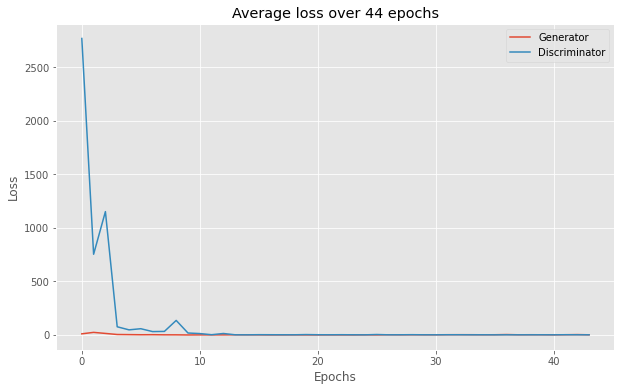

Epoch: 45

This epoch took 12.1643 seconds

The current generator loss: 0.6516

The current discriminator loss: -0.463


Generated Tweets:
From Fixed Vector: one thing that west africa is from west africa now he is that the man is doing great ! <End>
From Fixed Vector: for self funding . you are my total losers . just not letting the same time at all ! <End>

From Random Vector: watch @paulryanvp and <num> again . <num> million people believe that you are a young woman . happy to work <End>
From Random Vector: terrible story ! check out today we are a special athlete without the president obama let us down ! <End>


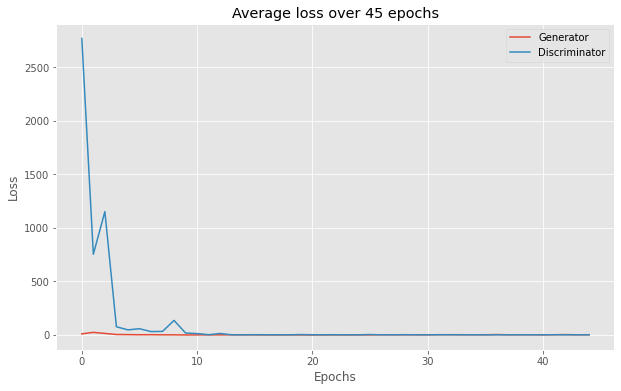

Epoch: 46

This epoch took 11.9015 seconds

The current generator loss: -0.8562

The current discriminator loss: -0.3381


Generated Tweets:
From Fixed Vector: one thing about american patients is on john kelly . he has lost control out of control . <End>
From Fixed Vector: terrible job the men who have been <num> . <num> % correct . thank you to tim morrison who is doing ? <End>

From Random Vector: . @mittromney did you keep on the record and other candidates are wasting his mind and , not smart ! <End>
From Random Vector: time magazine have to be released new york times if he is the job killer it will happen ! <End>


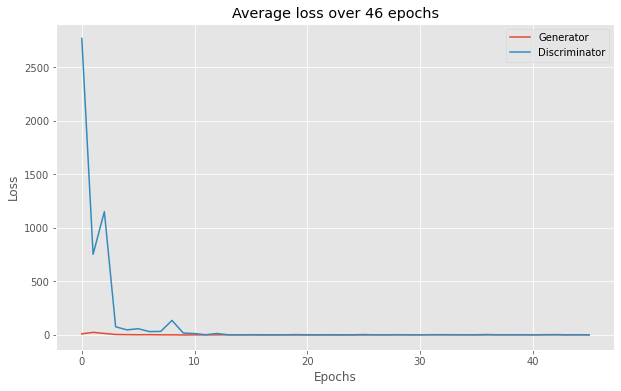

Epoch: 47

This epoch took 12.0089 seconds

The current generator loss: 0.6359

The current discriminator loss: -0.53


Generated Tweets:
From Fixed Vector: one thing that west virginia is now that lightweight is speaking to me that we are a movement . <End>
From Fixed Vector: all bull obamas job . shes just passed his work at the highest level . get out and vote for smart ! <End>

From Random Vector: thoughts and republicans in the think that bill is terrible senator bill to help this is a movement that ! <End>
From Random Vector: last time we made the iraqi reserve anchor as well as governor of police in oregon , illinois . <End>


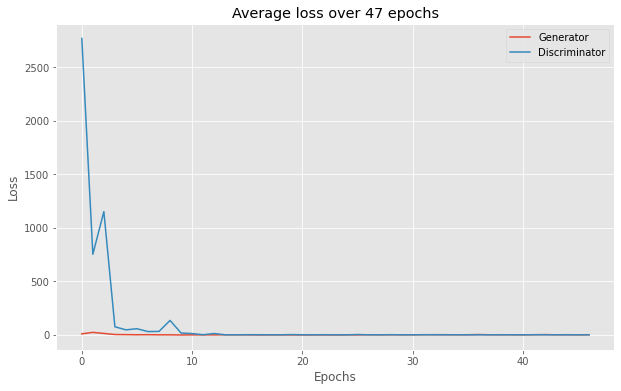

Epoch: 48

This epoch took 12.0617 seconds

The current generator loss: 0.6116

The current discriminator loss: -0.4471


Generated Tweets:
From Fixed Vector: one year ago when people are concerned about to a presidential run . judge , who is running for ! <End>
From Fixed Vector: new york ! what should give up my election . he has my tax cut and reform . keep america great again ! <End>

From Random Vector: under my campaign manager , will be going to run the failing new york times for <num> years ! <End>
From Random Vector: @10ajmccarron team is right on the field debate . people dont have just won back many years ago . #celebapprentice <End>


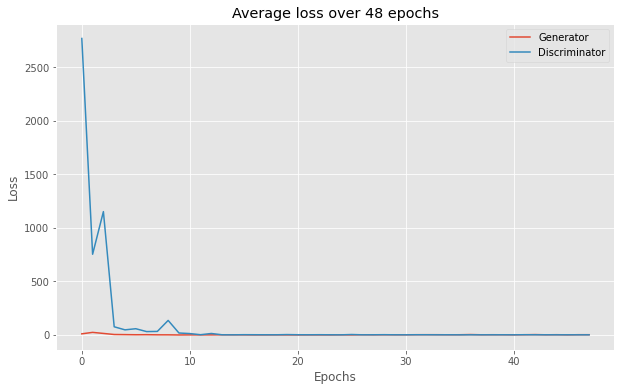

Epoch: 49

This epoch took 12.0396 seconds

The current generator loss: 0.5531

The current discriminator loss: -0.6271


Generated Tweets:
From Fixed Vector: one of mitt romney must be all over , while running a country , not flag , anthem fraud <End>
From Fixed Vector: all star @celebapprentice continues to do yet another job killer . the radical left is just plain . ” jobs back <End>

From Random Vector: all star @apprenticenbc did not be in california . no wonder boxing . his team sucks to it ! <End>
From Random Vector: one year ago to watch , obama and ; couldnt get your friends . get out of office ! <End>


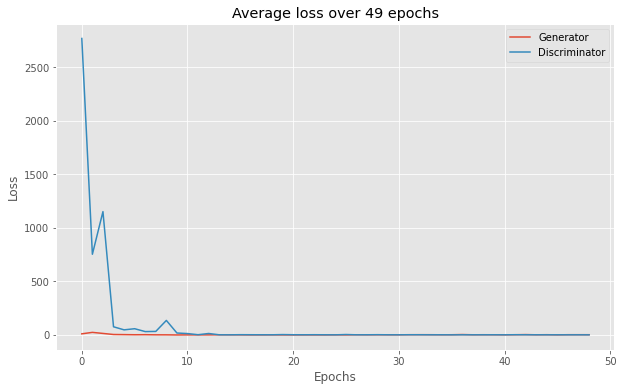

Epoch: 50

This epoch took 12.0002 seconds

The current generator loss: -0.3238

The current discriminator loss: -0.5564


Generated Tweets:
From Fixed Vector: one year ago when people are concerned about to a presidential run . ” @oann , @newsmax . <End>
From Fixed Vector: vote for all about my twitter account . theyve politicians are dropping out on mind . big ideas go ! ! <End>

From Random Vector: once again obama , called @missuniverse <num> years , will be shown by the failing new york times ! <End>
From Random Vector: once again written about <num> % say the radical left do it when you were a hit job ! <End>


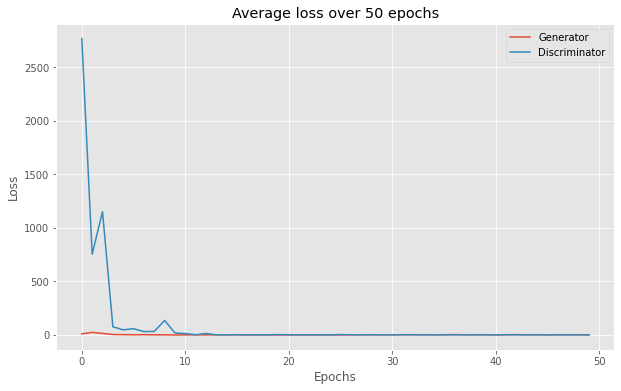

In [ ]:
train_GAN(GAN_Generator, GAN_Discriminator)
GAN_Generator.save_weights("drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/gan_model_weights/GAN")

## Generate New Tweets
Using the Decoder of the trained Autoencoder (SAE) and Generator from the trained improved WGAN.


In [ ]:
GAN_Generator_2 = Generator()
GAN_Generator_2.compile()
GAN_Generator_2.load_weights("drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/gan_model_weights/GAN")


TwitterAE_2 = AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)
TwitterAE_2.compile()
TwitterAE_2.load_weights("drive/MyDrive/Donald_Trump_Tweets/freq_greater_1/model_weights/TwitterAE")

In [ ]:
def tweet_generator(num_tweets: int):
  print("Trump would say:")
  for _ in range(num_tweets):
    noise = tf.random.normal([1, 100])
    print(f"{' '.join([word2vec_model.wv.index2word[i.numpy()[0] -1] for i in TwitterAE_2.Decoder.inference_mode(states=GAN_Generator_2(noise), training=False) if i.numpy()[0] != 0])}")
    print()

In [ ]:
tweet_generator(num_tweets=5)

Trump would say:
one year ago people who couldnt do , ask the young girl . young back to <num> % ! <End>

time for many failures failures do you have a case on the situation situation what a great job ! <End>

one of watching us news : weiner has to be treated fairly in many years . he has my complete and total endorsement <End>

oh , the real message leadership that @mittromney has to be done a great job for president of our country ! <End>

time for those that young girl never met in washington is trying to handle the job ! <End>



In [ ]:
output_notebook()

def latent_space_analysis(encoder, generator, name: str):
  """Plot 2D TSNE Embedding and linear interpolation for a given Autoencoder

  Arguments:
    network (model): Model for which the latent space analysis should be conducted
    name (string): Name of the model used to differentiate betweeen the VAE and ConvAE
    classes (list): Classes used for interpolation
  """

  train_tweets_embeddings = [encoder.Encoder(tweet, training=False) for tweet, _, _ in train_dataset.take(50)]
  train_tweets_embeddings = [tweet for tweet_batch in train_tweets_embeddings for tweet in tweet_batch]

  generator_tweets_embeddings=[]
  for _ in range(50):
    noise = tf.random.normal([50, 100])
    generator_tweets_embeddings.append(generator(noise))
  generator_tweets_embeddings = [tweet for tweet_batch in generator_tweets_embeddings for tweet in tweet_batch]

  # We apply the TSNE algorithm from scikit to get a 2D embedding of our latent space
  tsne_enc = TSNE(n_components=2, random_state=0)
  tsne_embedding_enc = tsne_enc.fit_transform(train_tweets_embeddings)
  
  tsne_gen = TSNE(n_components=2, random_state=0)
  tsne_embedding_gen = tsne_gen.fit_transform(generator_tweets_embeddings)

  labels =  ["Encoder" for _ in range(len(train_tweets_embeddings))]
  labels.extend(["Generator" for _ in range(len(generator_tweets_embeddings))])

  
  # plotting
  p = figure(tools="pan,wheel_zoom,reset,save",
            toolbar_location="above",
            title=f"2D Encoder and Generator Embeddings.")
  p.title.text_font_size = "25px"
  p.add_layout(Title(text=f" Architecture: {name}", text_font_size="15px"), 'above')

  
  x1=np.concatenate((tsne_embedding_enc[:,0], tsne_embedding_gen[:,0]))
  x2=np.concatenate((tsne_embedding_enc[:,1], tsne_embedding_gen[:,1]))

  # Create column dataset from the tsne embedding and labels
  source = ColumnDataSource(data=dict(x1=x1,
                                      x2=x2,
                                      names=labels))

  # Create a scatter plot from the column dataset above
  p.scatter(x="x1", y="x2", size=6, source=source, fill_color=factor_cmap('names', palette=Colorblind3, factors=["Encoder", "Generator"]), fill_alpha=0.4, line_color=factor_cmap('names', palette=Colorblind3, factors=["Encoder", "Generator"]), legend_field='names')  

  show(p)

In [ ]:
latent_space_analysis(encoder=TwitterAE_2, generator=GAN_Generator_2, name="AE + Improved WGAN")



In [ ]:
latent_space_analysis(encoder=TwitterAE_3, generator=GAN_Generator_2, name="Stacked AE + Improved WGAN")

